In [1]:
# Standard library imports
import os
import string
from string import ascii_uppercase as abc; abc = abc
import warnings

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook
import matplotlib.cm as cm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.gridspec import GridSpec
import seaborn as sns
from adjustText import adjust_text
# SciPy and related imports
from scipy import stats
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline as spline_interp
from scipy.stats import rankdata, spearmanr, pearsonr, linregress
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.fftpack import rfft, fft, fftfreq, rfftfreq
from scipy.signal import medfilt, find_peaks
from scipy.io import loadmat
from scipy.optimize import curve_fit, brute, basinhopping

# SymPy imports
from sympy import *

# scikit-learn imports
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score

# Statsmodels imports
from statsmodels.stats.multitest import fdrcorrection

# qpsolvers import
from qpsolvers import solve_qp

# tqdm imports
try:
    from tqdm.notebook import tqdm, trange
except ImportError:
    from tqdm import tqdm_notebook as tqdm

In [2]:
# Setup logging and globabl plotting parameters
warnings.filterwarnings("ignore")
matplotlib_axes_logger.setLevel('ERROR')
np.seterr(divide='ignore', invalid='ignore')
def_color  = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
init_printing()
plt.rc('font', size=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.rc('axes', titlesize=8) 
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams['font.family'] = 'sans-serif'
plt.rcParams["svg.fonttype"] = "none"

In [3]:
def remove_top_right_frame(axes):
    for ax in axes:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

def remove_axe_labels(ax):
    ax.set_title('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
        
def to_dict(keys,values):
    return dict(zip(keys,values))

def get_test_dataframe(path,file):
    tdf       = pd.read_csv(path+file)
    tdf.index = np.array([np.array(s.replace('[','').replace(')','').split(',')).astype(int).mean() for s in tdf['week']])
    tdf       = tdf.drop(columns=['week'])
    tdf.rename(columns={"age50": "age"},inplace=True)
    #tdf.rename(columns={"age_50": "age"},inplace=True)
    if len(tdf)<140:
        missing_index = np.sort(list(set(np.arange(-59.5,80.5,1)) - set(tdf.index)))
        tdf = tdf.T
        [tdf.insert(int(np.argwhere(np.arange(-59.5,80.5,1) == missing_index[i])[0][0]),missing_index[i],np.nan) for i in range(len(missing_index))]
        tdf = tdf.T
    return tdf

# Loading the dataset

In [4]:
path     = '../Clalit Data/pregnancy.1w/'
files    = list(filter(lambda x: os.path.isfile(os.path.join(path, x)), [file for file in os.listdir(path)]))
all_tests= [file.split('.')[0] for file in files]
dfs      = dict(zip(all_tests,[get_test_dataframe(path,file) for file in files]))

# Loading metadata

In [5]:
'''
Code to create dataframe of tests values by percentile from LabNorm package in R (https://github.com/tanaylab/labNorm)

library(labNorm)
df1 = data.frame()
df2 = data.frame()

for (idx in 1:93) {
  dat1<-ln_quantile_value(c(0,0.01,0.03,0.10,0.15,0.25,0.35,0.50,0.65,0.75,0.85,0.90,0.97,0.99,1), seq(20, 40, by = 1), "female", LAB_DETAILS$short_name[idx])
  df1 <- rbind(df, dat1)}

write.csv(df1,file='pregnancy/LabNorm.csv', row.names=FALSE)
'''
groups        = ['Liver','Renal','Musculoskeletal','Metabolism','RBCs','Coagulation','Immune','Endocrine']
subgroups_main= ['Liver','Renal I','Renal II','Musculoskeletal','Metabolism','RBCs I','RBCs II','Coagulation','Immune I','Immune II','Endocrine']
subgroups_si  = ['Liver','Renal I','Renal II','Musculoskeletal','Metabolism','RBCs I','RBCs II','RBCs III','Coagulation','Immune I','Immune II','Immune III','Endocrine I','Endocrine II','Endocrine III']
metadata      = pd.read_excel('../Metadata.xlsx',index_col=0)#.drop(remove)
labnorm       = pd.read_csv('../LabNorm.csv')
labnorm_tests = list(metadata.loc[~metadata['LabNorm name'].isna()].index)

# Functions to process the data

In [6]:
def get_age_matched_reference(test):
    age  = int(np.nanmedian(dfs[test]['age_mean']))
    tdf  = labnorm.loc[(labnorm.age==age)&(labnorm.lab==metadata.loc[test]['LabNorm name'])].fillna(method='ffill').fillna(method='bfill').copy()
    tdf['value'].loc[tdf.value<0] = np.min(tdf['value'].loc[tdf.value>0])
    prob = np.diff(tdf['quantile'])/np.sum(np.diff(tdf['quantile']))
    mu_  = (tdf.value.iloc[1:]*prob).sum()
    sd_  = np.sqrt((prob*((tdf.value.iloc[1:] - mu_)**2)).sum())
    q_to_val = interp1d(tdf['quantile'],tdf['value'],kind='linear')
    return {'quantile':q_to_val,'mean':mu_,'sd':sd_}

def get_mean_stats(test):
    tdf = dfs[test]
    #n   = tdf['n']
    n   = tdf['val_n']
    #v   = tdf['mean']
    v   = tdf['val_mean']
    e   = tdf['val_sd']/np.sqrt(tdf['val_n'])
    # e = tdf["sd"] /np.sqrt(tdf['n'])
    return pd.DataFrame(np.array([n,v,e]).T,index=tdf.index,columns=['n','value','error'])

def get_quantile_stats(test):
    tdf = dfs[test]
    # n   = tdf['n']
    n   = tdf['val_n']
    # v   = tdf['qmean']
    v = tdf["qval_mean"]
    # e   = (tdf['qq75'] - tdf['qq25'])/(np.sqrt(tdf['n'])*0.675*2)
    e = tdf["qval_sd"] /np.sqrt(tdf['val_n'])
    return pd.DataFrame(np.array([n,v,e]).T,index=tdf.index,columns=['n','value','error'])

def get_value_at_quantile_stats(test):
    tdf = get_quantile_stats(test)
    if test in labnorm_tests:
        ref = get_age_matched_reference(test)
        v   = ref['quantile'](tdf['value'])
        e_p = ref['quantile']((tdf['value']+tdf['error']).clip(upper=1))
        e_m = ref['quantile']((tdf['value']-tdf['error']).clip(lower=0))
        e   = (e_p - e_m)/2
        return pd.DataFrame(np.array([tdf['n'],v,e]).T,index=tdf.index,columns=['n','value','error'])
    else:
        return pd.DataFrame(index=tdf.index,columns=['n','value','error'])

def get_postpartum_SDS_stats(test):
    df       = get_quantile_stats(test)
    df['sd'] = df['error']*np.sqrt(df['n'])    
    mu_end   = np.sum(df.loc[70:]['n']*df.loc[70:]['value'])/(np.sum(df.loc[70:]['n']))
    sd_end   = np.sqrt(np.sum(df.loc[70:]['n']*df.loc[70:]['sd']**2)/(np.sum(df.loc[70:]['n'])))    
    v        = (df['value'] - mu_end) / sd_end
    e        = df['error'] / sd_end
    return pd.DataFrame(np.array([df['n'],v,e]).T,index=df.index,columns=['n','value','error']).loc[0:]    
     
def get_test_data(test):
    return {'mean'             :get_mean_stats(test),
            'quantile'         :get_quantile_stats(test),
            'value_at_quantile':get_value_at_quantile_stats(test),
            'postpartum_SDS'   :get_postpartum_SDS_stats(test)}

def get_stats_from_dataset(test,stat,period=[-60,80],merge_timepoints = True):
    
    df       = data[test][stat].copy()
    df['sd'] = df['error']*np.sqrt(df['n'])
 
    split_k = 1
    if merge_timepoints:
        split_k  = np.min([int(np.ceil(np.nanmean((df['error']/(df['value'].std() * 0.15))**2))),7])
        
        if split_k > 1:
            print(f"merge happened in test {test}: {int(split_k)}")
            df     = df.reset_index()
            splits = np.array_split(df, int(len(df)/split_k))
            x      = np.array([tdf['index'].mean()                                   for tdf in splits])
            n      = np.array([tdf['n'].sum()                                        for tdf in splits])
            v      = np.array([np.sum(tdf['value']*tdf['n'])/tdf['n'].sum()          for tdf in splits])
            sd     = np.array([np.sqrt(np.sum(tdf['sd']**2*tdf['n'])/tdf['n'].sum()) for tdf in splits])
            e      = sd/np.sqrt(n)
            df     = pd.DataFrame(np.array([n,v,e]).T,columns=['n','value','error'],index=x)
   
    df = df.loc[period[0]:period[1]]
    x  = df.index
    n  = df.n
    v  = df['value']
    e  = df['error']
    return x,v,e,n    

In [7]:
data = {test:get_test_data(test) for test in tqdm(all_tests)}

  0%|          | 0/110 [00:00<?, ?it/s]

### Some general information about the dataset

In [9]:
ages = [(dfs[k]["val_n"] * dfs[k]["age_mean"]).sum() / dfs[k]["val_n"].sum() for k in dfs ]
print(f"Average age: {sum(ages) / len(ages)}")
print(f"Total measurements: {int(sum([(dfs[k]['val_n']).sum() for k in dfs ])):,}")

28.53925079934239
44,312,918
495,103


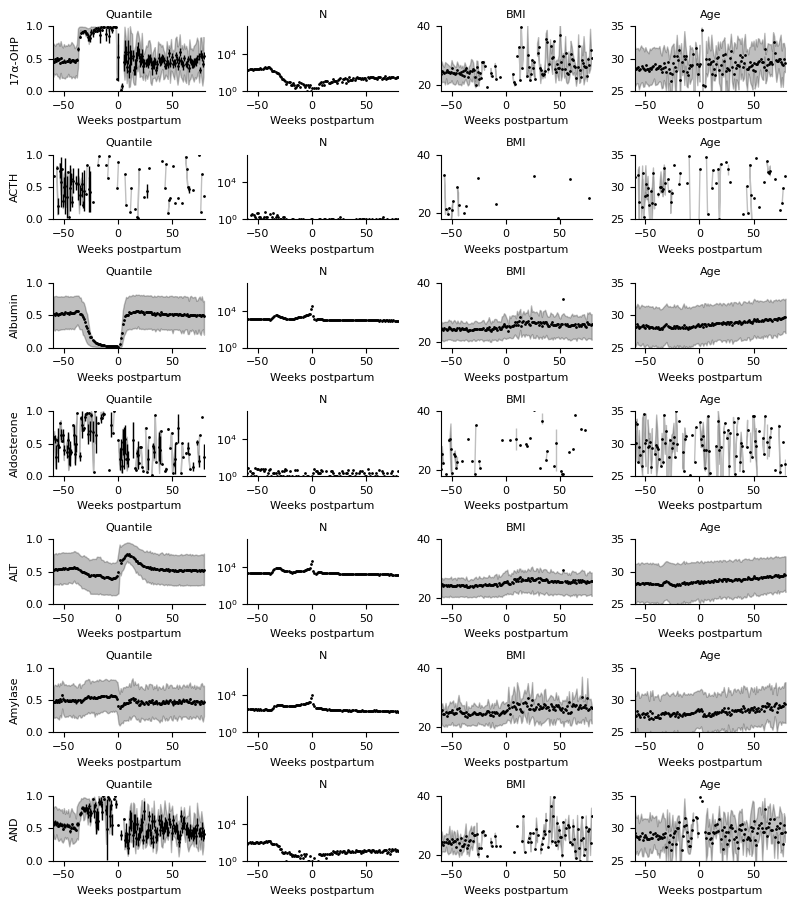

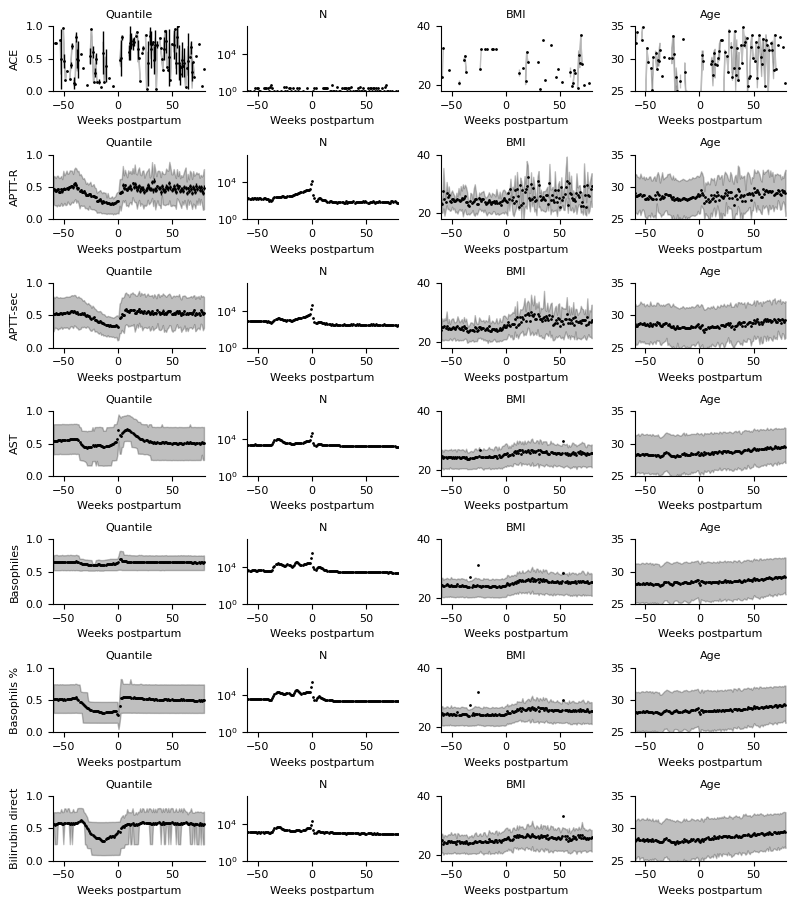

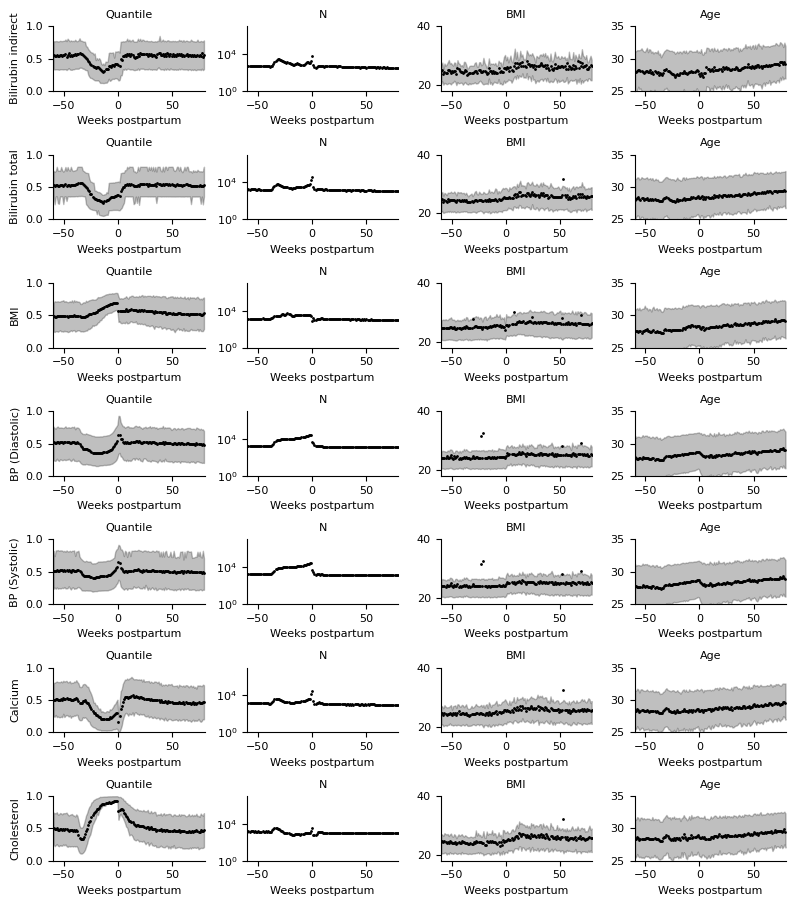

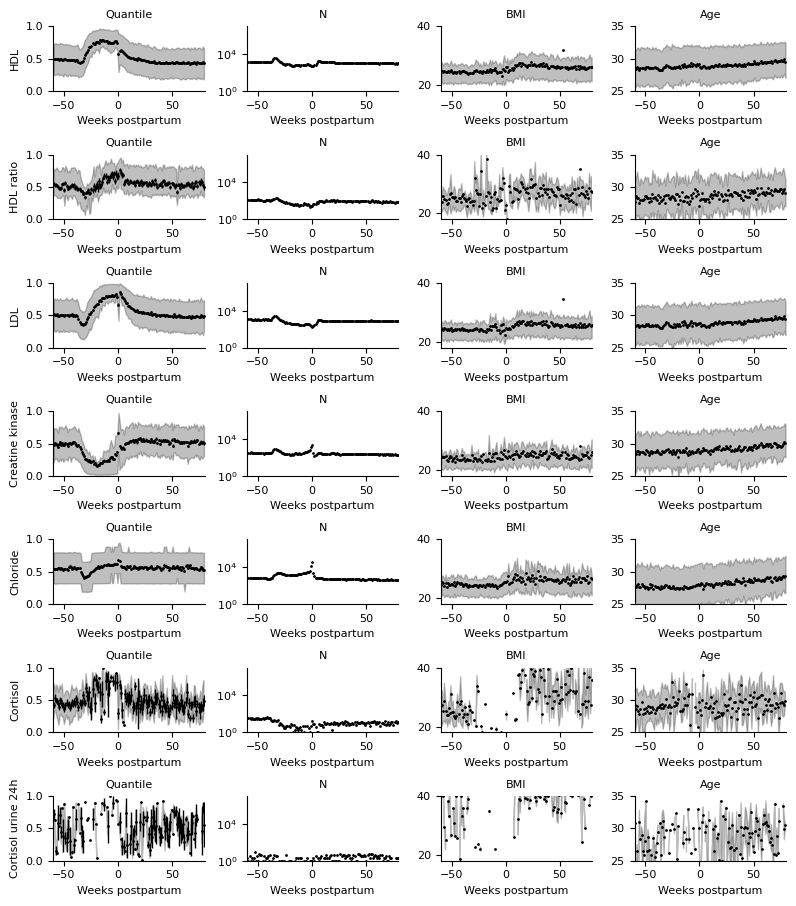

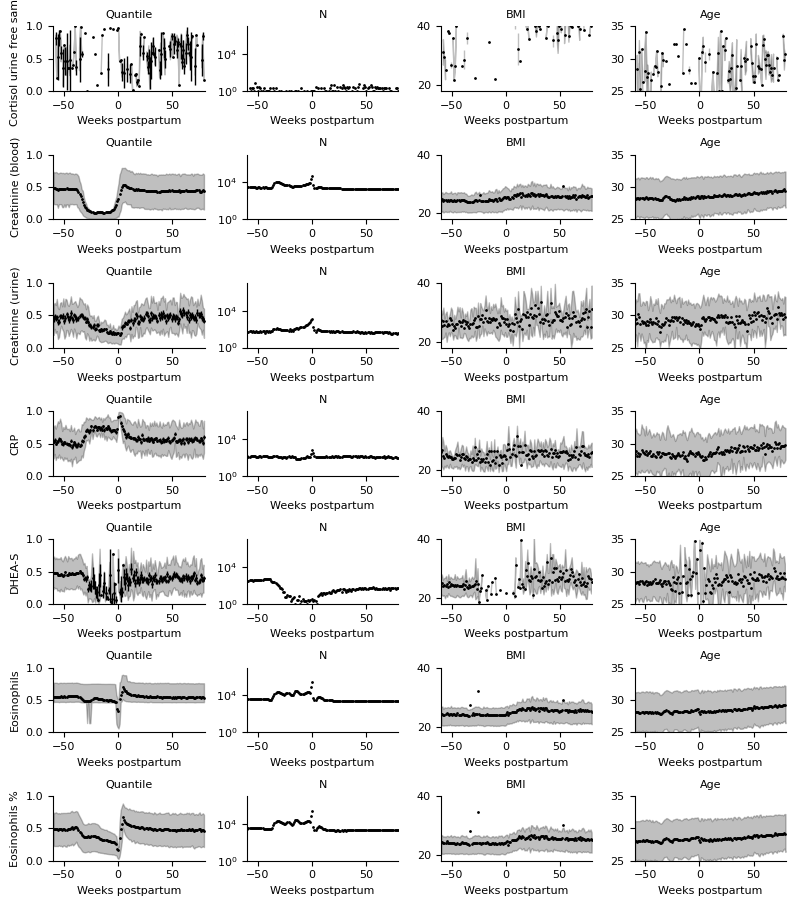

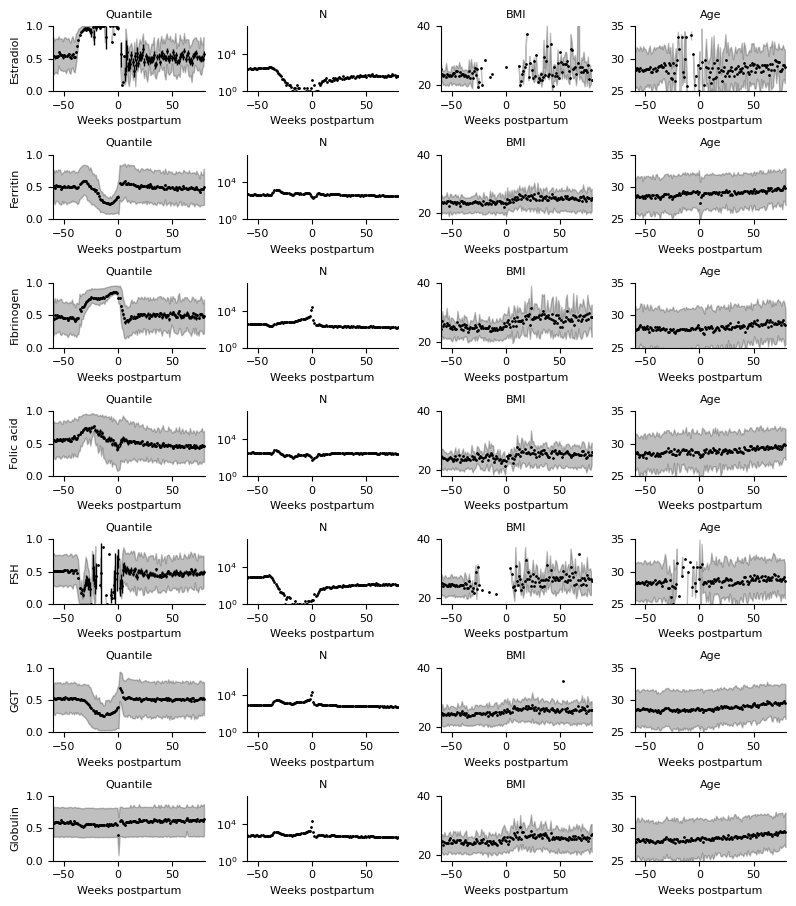

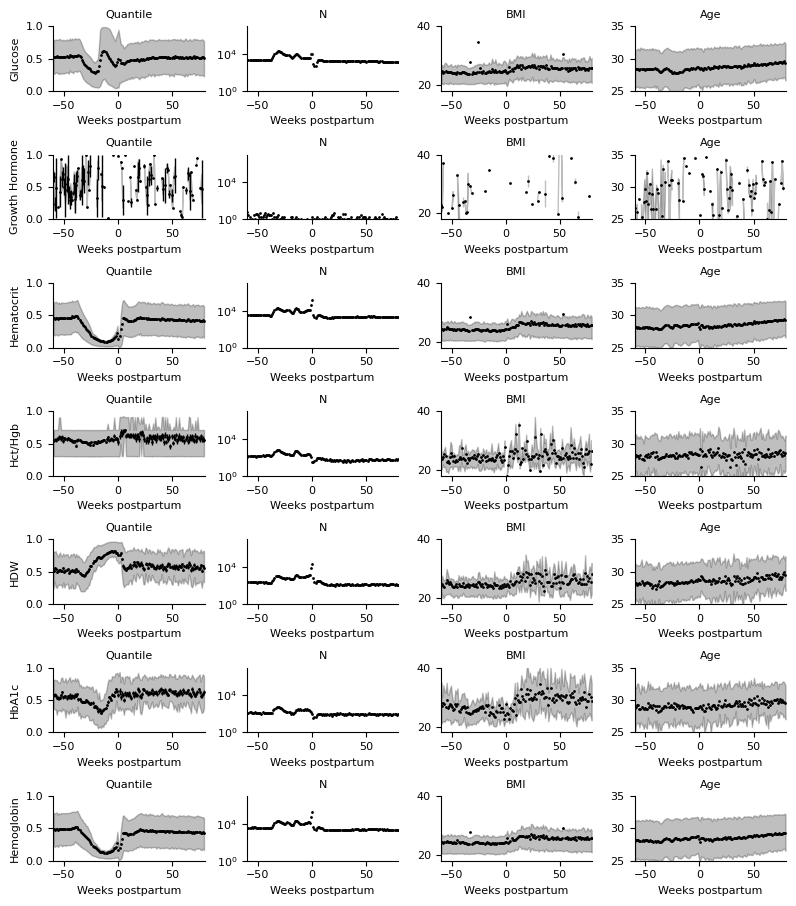

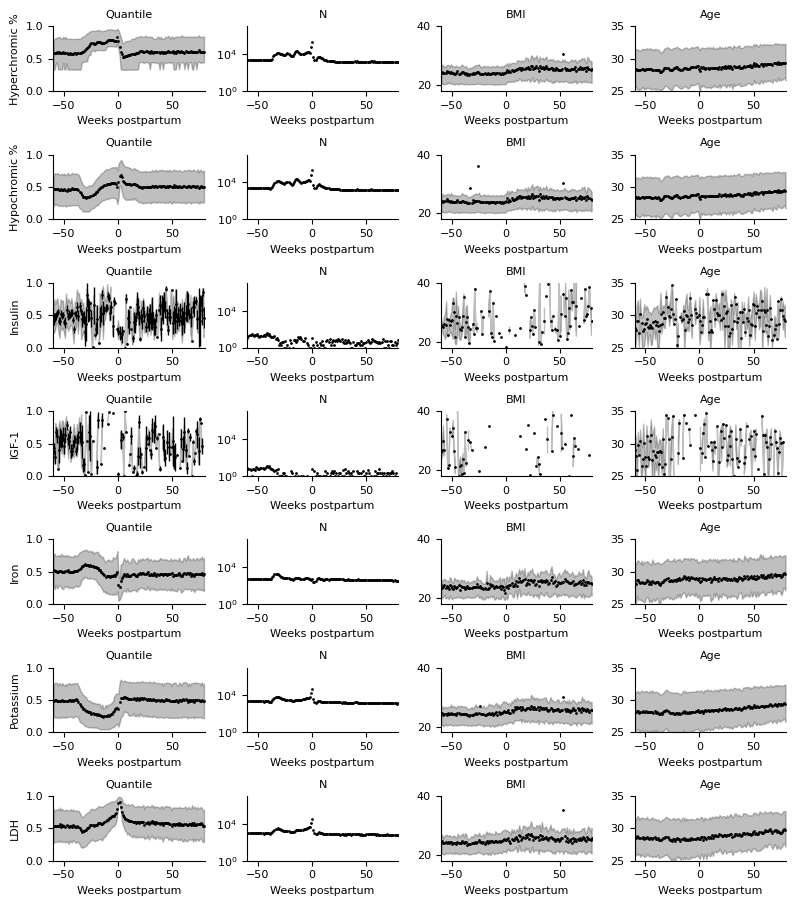

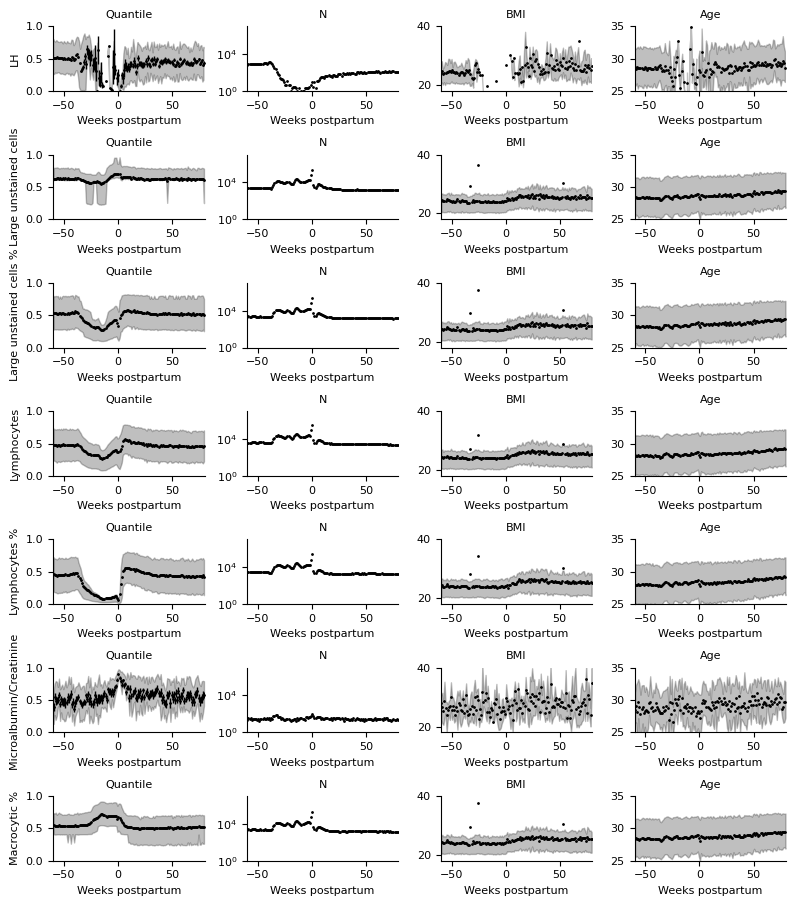

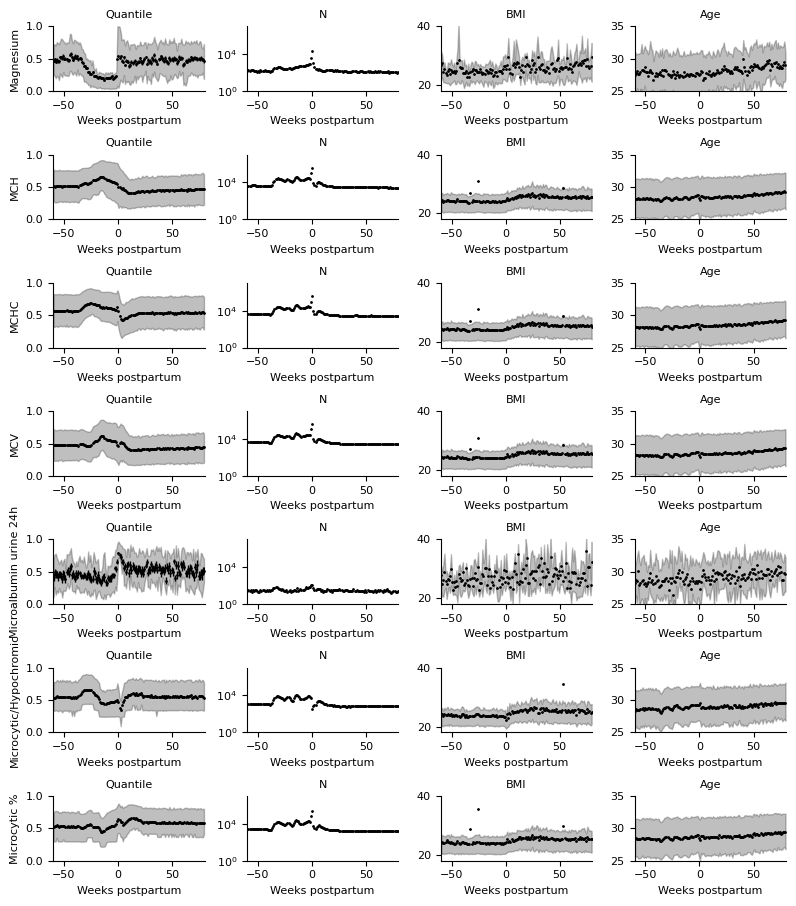

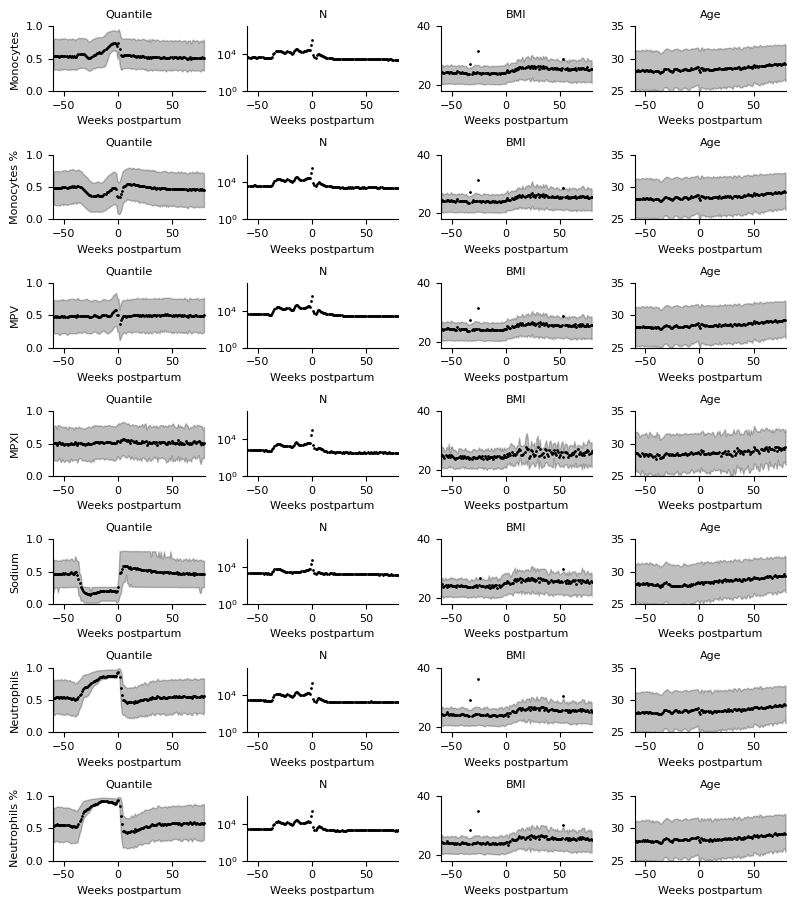

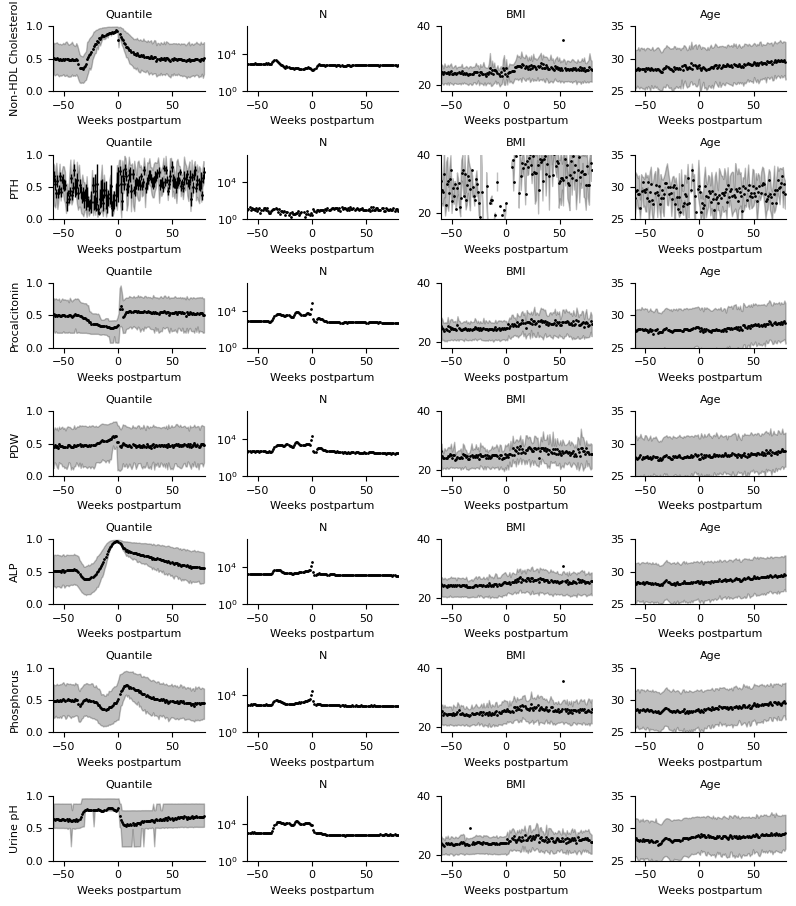

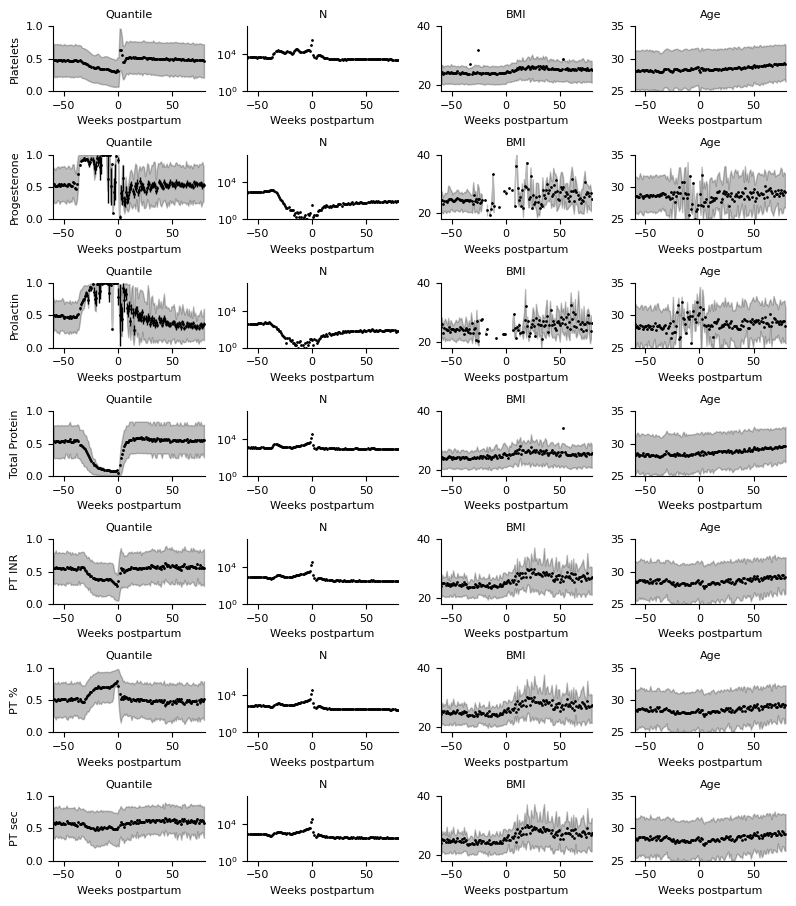

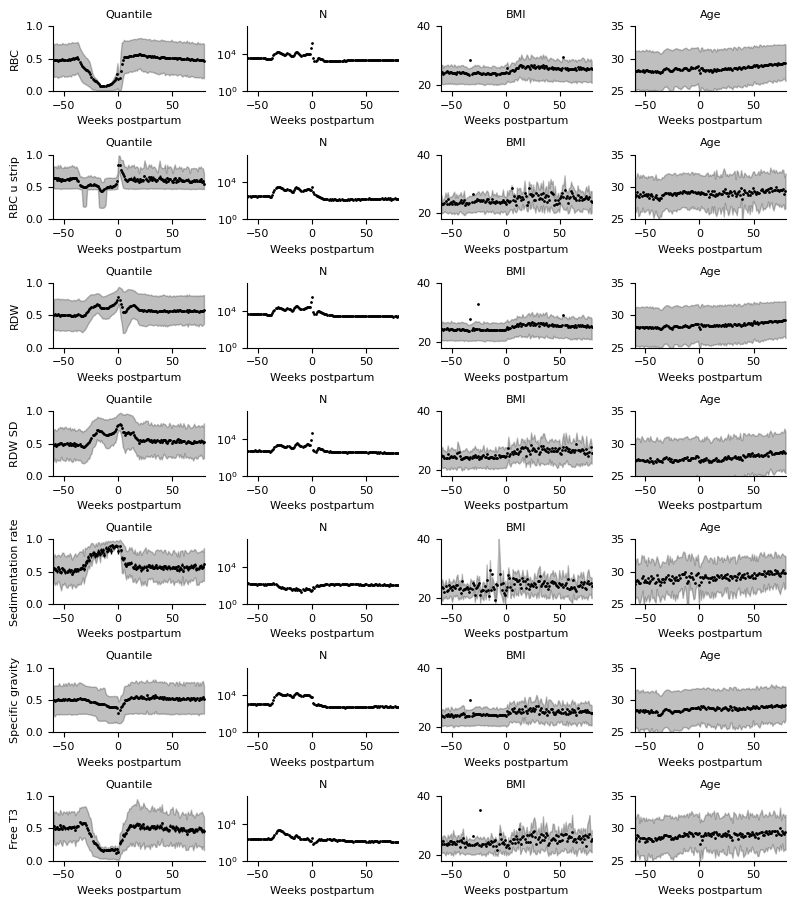

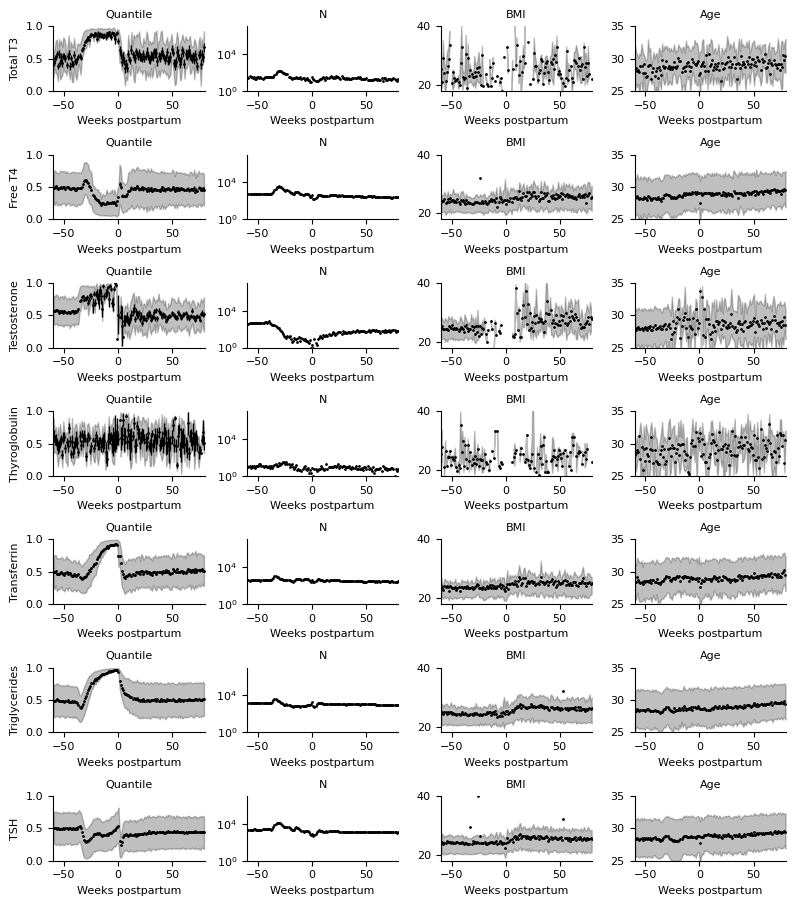

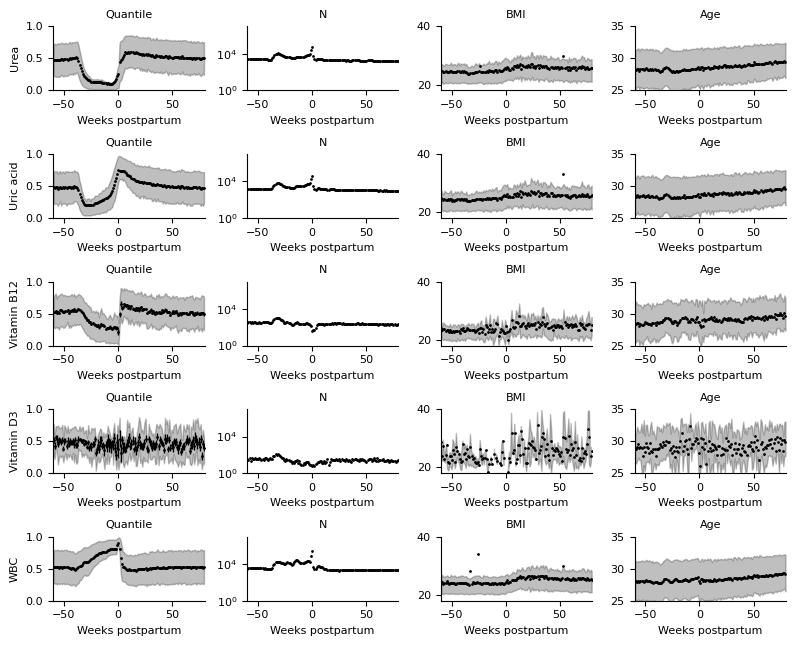

In [10]:
for j in range((len(all_tests) -1)//7 + 1):
    
    tests = all_tests[j*7:j*7+7]
    plt.figure(figsize=(8,1.3*len(tests)))
    for i,test in enumerate(tests):
        ax1,ax2,ax3,ax4   = plt.subplot(len(tests),4,1+4*i),plt.subplot(len(tests),4,2+4*i),plt.subplot(len(tests),4,3+4*i),plt.subplot(len(tests),4,4+4*i)
        x,v,e,n           = get_stats_from_dataset(test,'quantile',merge_timepoints = False)
        bmi25,bmi50,bmi75 = dfs[test]['bmi_25'],dfs[test]['bmi_mean'],dfs[test]['bmi_75']
        #bmi25,bmi50,bmi75 = dfs[test]['bmi_25'],dfs[test]['bmi_50'],dfs[test]['bmi_75']
        age25,age50,age75 = dfs[test]['age_25'],dfs[test]['age_mean'],dfs[test]['age_75']
        #age25,age50,age75 = dfs[test]['age_25'],dfs[test]['age'],dfs[test]['age_75']


        ax1.errorbar(x,v,e,fmt='o',markersize=1,c='k',elinewidth=1); ax1.set_title('Quantile'); ax1.set_xlabel('Weeks postpartum')
        ax2.plot(x,n,marker='o',markersize=1,c='k',lw=0)           ; ax2.set_title('N')       ; ax2.set_xlabel('Weeks postpartum')
        ax3.plot(x,bmi50,marker='o',markersize=1,c='k',lw=0)       ; ax3.set_title('BMI')     ; ax3.set_xlabel('Weeks postpartum')
        ax4.plot(x,age50,marker='o',markersize=1,c='k',lw=0)       ; ax4.set_title('Age')     ; ax4.set_xlabel('Weeks postpartum')

        #ax1.fill_between(x,dfs[test]['qq25'],dfs[test]['qq75'],alpha=0.25,color='k')
        ax1.fill_between(x,dfs[test]['qval_25'],dfs[test]['qval_75'],alpha=0.25,color='k')
        ax3.fill_between(x,bmi25,bmi75,alpha=0.25,color='k')
        ax4.fill_between(x,age25,age75,alpha=0.25,color='k')

        ax1.set_ylim([0,1])   ; ax1.set_xlim([-60,80])
        ax2.set_ylim([10e-1,10e6])   ; ax2.set_xlim([-60,80]); ax2.set_yscale('log')
        ax3.set_ylim([18,40]) ; ax3.set_xlim([-60,80])
        ax4.set_ylim([25,35]) ; ax4.set_xlim([-60,80])

        ax1.set_ylabel(metadata.loc[test]['Nice name'])
        remove_top_right_frame([ax1,ax2,ax3,ax4])
    plt.tight_layout();
    plt.savefig('S_1_'+str(j)+'.jpg',bbox_inches = 'tight',dpi=300);
    plt.show() 


# We focus on 76 of the tests for our analysis

In [11]:
#pd.read_csv('../Files/tests_in_analysis.csv',index_col=0).values.flat[:]

In [12]:
def filter_tests_from_data(data, field="value_at_quantile", min_n=50, min_avg_n=90, max_avg_noise=0.5, max_noise=0.7, min_weeks=-60, max_weeks=80, res=1):
    tests = set()
    num_points = (max_weeks - min_weeks) / res
    for k in data:
        df = data[k][field]
        noise = (df['error'] / df['value'].var() ** 0.5)
        is_noisy = (noise.mean() > max_avg_noise or noise.max() > max_noise) or noise.isna().any()
        enough_n_vals = df["n"].min() > min_n and df["n"].mean() > min_avg_n
        n_points = len(df.index)
        if (n_points == num_points and enough_n_vals and not is_noisy):
            tests.add(k)
    return tests
        
        

In [13]:
tests = np.array(sorted(filter_tests_from_data(data)))
print(f"Total number of included tests: {len(tests)}")
print(f"Total n in incldued tests: {int(sum([(dfs[k]['val_n']).sum() for k in tests ])):,}")

def basic_age_demographics(at_index):
    ages_25 = []
    ages_mean = []
    ages_75 = []
    weights = []
    cols = ["age_25", "age_mean", "age_75", "val_n"]
    for test in tests:
        age_25, age_mean, age_75, weight = dfs[test].loc[at_index, cols]
        ages_25.append(age_25)
        ages_mean.append(age_mean)
        ages_75.append(age_75)
        weights.append(weight)
        mean_all_ages = np.average(ages_mean, weights=weights)
        mean_age_25 = np.average(ages_25, weights=weights)
        mean_age_75 = np.average(ages_75, weights=weights)
    print(f"{mean_all_ages:.1f} ({mean_age_25:.1f}-{mean_age_75:.1f})")

basic_age_demographics(-59.5)
basic_age_demographics(-0.5)
basic_age_demographics(79.5)

def basic_bmi_demographics(at_index):
    cols = ["val_25", "val_mean", "val_75", "val_n"]
    bmi_25, bmi_mean, bmi_75, weight = dfs["BMI"].loc[at_index, cols]
    print(f"{bmi_mean:.1f} ({bmi_25:.1f}-{bmi_75:.1f})")

basic_bmi_demographics(-59.5)
basic_bmi_demographics(-1.5)
basic_bmi_demographics(78.5)


76
43,498,258
28.2 (25.2-31.3)
28.3 (25.3-31.4)
29.3 (26.6-32.3)
24.6 (20.7-27.1)
28.8 (25.1-31.7)
26.0 (20.9-29.4)
36,043	1,652,191


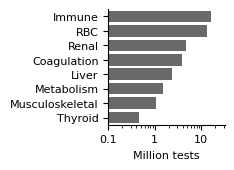

In [14]:
#ndf          = pd.DataFrame([dfs[test]['n'] for test in tests],index=tests).fillna(0).astype(int)
ndf          = pd.DataFrame([dfs[test]['val_n'] for test in tests],index=tests).fillna(0).astype(int)
tdf          = pd.DataFrame(index=tests)
tdf['n']     = ndf.sum(axis=1)
tdf['group'] = metadata["Group"][tdf.index]


temp          = pd.DataFrame([tdf.loc[tdf['group'] == group]['n'].sum() for group in groups],index=groups,columns=['n'])
temp['group'] = temp.index
temp          = temp.sort_values(by=['n'],ascending=False)
temp['group'].iloc[1] = 'RBC'
temp['group'].iloc[-1] = 'Thyroid'

plt.figure(figsize=(1.5,1.5))
ax = plt.subplot(111)
sns.barplot(data=temp,y='group',x='n',ax=ax,orient='h',color='dimgray')
ax.set_ylabel('')
ax.set_xscale('log')
ax.set_xlim([10**5,10**7.5])
ax.set_xticklabels(['','0.1','1','10'])
ax.set_xlabel('Million tests')
remove_top_right_frame([ax])
plt.savefig('M_1A.svg',bbox_inches = 'tight',dpi=300)
plt.show()

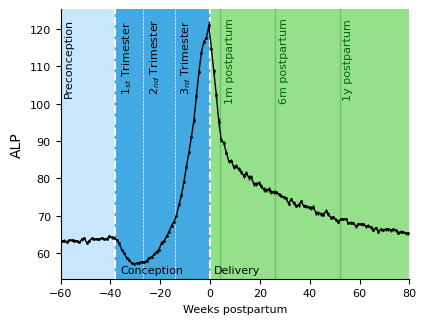

In [15]:
test      = 'PHOSPHATASE_ALKALINE'
stat      = 'value_at_quantile'
x,v,e,n   = get_stats_from_dataset(test,stat, merge_timepoints=False)
ref       = get_age_matched_reference(test)
ref_val   = ref['quantile'](0.5)
ylabel    = 'Value at mean quantile'
ref_label = "Reference Population Median"

plt.figure(figsize=(4.5,3.5))    
ax      = plt.subplot(111)
ax.errorbar(x,v,e,c='k',lw=1,fmt='-o',markersize=1,zorder=-3)
ax.set_xticks(np.arange(-60,100,20))
ax.set_xlabel('Weeks postpartum')
ax.set_ylabel(metadata.loc[test]['Nice name'],fontsize=10)# + ylabel)
ax.set_xlim([-60,80])
ax.set_ylim(ax.get_ylim()[0]*0.99,ax.get_ylim()[1])
ax.axvspan(-60,-38,color='#C8E7FD',zorder=-5)
ax.axvspan(-38,0,color='#43A9E2',zorder=-5)
ax.axvspan(0,80,color='#95E08B',zorder=-5)
ax.axvline(x=4,c='darkgreen',ls='-',zorder=-3,lw=1,alpha=0.25)
ax.axvline(x=26,c='darkgreen',ls='-',zorder=-3,lw=1,alpha=0.25)
ax.axvline(x=52,c='darkgreen',ls='-',zorder=-3,lw=1,alpha=0.25)
ax.axvline(x=-27,c='white',ls='--',zorder=-4,lw=0.5)
ax.axvline(x=-14,c='white',ls='--',zorder=-4,lw=0.5)
ax.axvline(x=-38,c='white',ls='--',zorder=-4)
ax.axvline(x=0,c='white',ls='--',zorder=-4)
ax.annotate('1m postpartum',xy=(0.47,0.66),xycoords='axes fraction',rotation = 90,c='darkgreen',alpha=0.99)
ax.annotate('6m postpartum',xy=(0.625,0.66),xycoords='axes fraction',rotation = 90,c='darkgreen',alpha=0.99)
ax.annotate('1y postpartum',xy=(0.81,0.67),xycoords='axes fraction',rotation = 90,c='darkgreen',alpha=0.99)
ax.annotate('Preconception',xy=(0.01,0.68),xycoords='axes fraction',rotation = 90,alpha=0.99)
ax.annotate('$1_{st}$ Trimester',xy=(0.17,0.7),xycoords='axes fraction',rotation = 90,alpha=0.99)
ax.annotate('$2_{nd}$ Trimester',xy=(0.25,0.7),xycoords='axes fraction',rotation = 90,alpha=0.99)
ax.annotate('$3_{rd}$ Trimester',xy=(0.34,0.7),xycoords='axes fraction',rotation = 90,alpha=0.99)
ax.annotate('Conception',xy=(0.17,0.02),xycoords='axes fraction',alpha=0.99)
ax.annotate('Delivery',xy=(0.44,0.02),xycoords='axes fraction',alpha=0.99)
remove_top_right_frame([ax])
plt.savefig('M_1B.svg',bbox_inches = 'tight',dpi=300); plt.show()

merge happened in test AMYLASE_BLOOD: 7
merge happened in test APTT_R: 4
merge happened in test APTT_sec: 2
merge happened in test BASOPHILES_abs: 2
merge happened in test BILIRUBIN_INDIRECT: 2
merge happened in test BPs: 2
merge happened in test CK_CREAT: 2
merge happened in test FERRITIN: 2
merge happened in test FOLIC_ACID: 3
merge happened in test GLOBULIN: 4
merge happened in test HDW: 2
merge happened in test IRON: 3
merge happened in test MAGNESIUM_BLOOD: 2
merge happened in test MICROperc_HYPOperc: 2
merge happened in test MPV: 3
merge happened in test PDW: 6
merge happened in test PT_SEC: 4
merge happened in test RDW_SD: 2
merge happened in test SPECIFIC_GRAVITY: 5
merge happened in test T3_FREE: 2
merge happened in test T4_FREE: 2


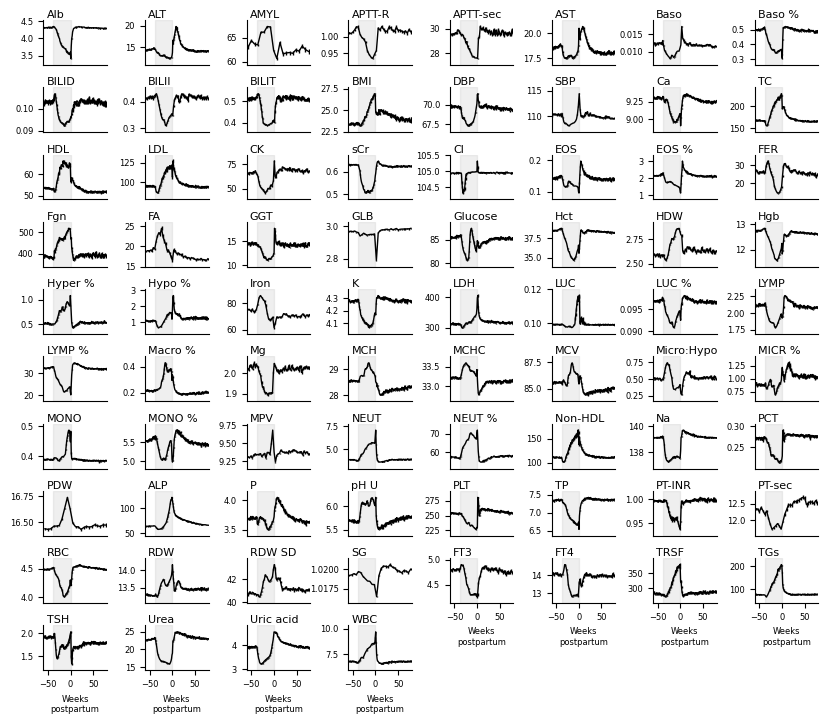

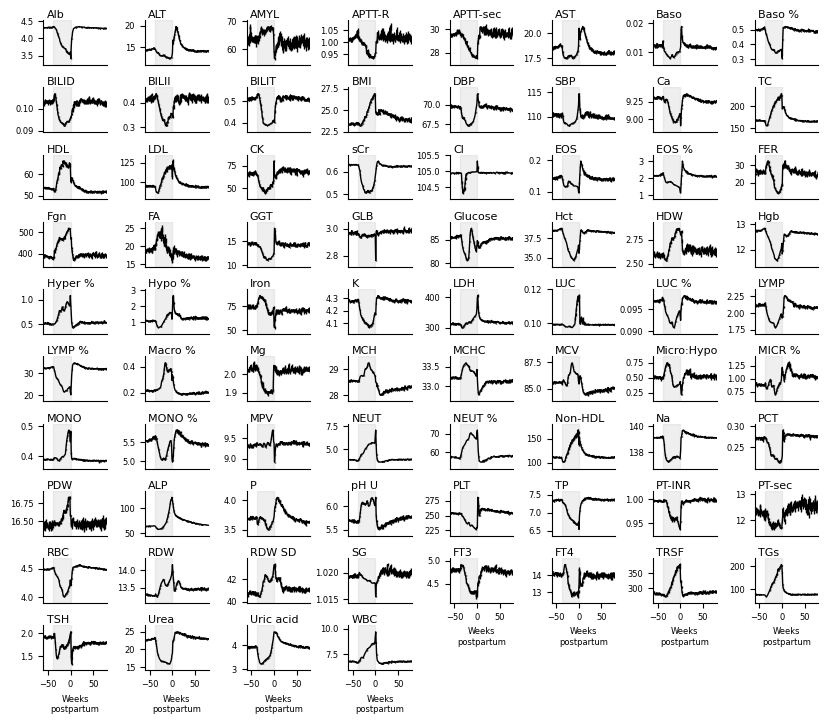

In [16]:
def plot_qunatile_change(ax,test, merge_timepoints=True):
    qstd   = pd.DataFrame([data[test]['value_at_quantile']['value'].std() for test in tests],index = tests)


    x,v,e,n = get_stats_from_dataset(test,'value_at_quantile', merge_timepoints=merge_timepoints)
    
    ylim_   = np.max(v) + (np.max(v)-np.min(v))*0.2
    ylim_1  = np.min(v) - (np.max(v)-np.min(v))*0.2
    
    ax.errorbar(x,v,e,c='k',lw=1)
    # ax.set_ylabel('Percentile\nChange',fontsize=6); 

    ax.set_ylim([ylim_1,ylim_])
    ax.set_xticks(np.arange(-50,100,50)) ; ax.set_xlabel('Weeks\npostpartum',fontsize=6); ax.set_xlim([-60,80])
    ax.axvspan(-38,0,color='dimgray',alpha=0.1,zorder=-20)

    ax.set_facecolor('w')
    remove_top_right_frame([ax])
    ax.annotate(metadata.loc[test]['Short name'],(0.05,1.05),xycoords='axes fraction',fontsize=8,color='k')
    ax.tick_params(axis='both', which='major', labelsize=6)

plt.figure(figsize=(10,np.ceil(len(tests))/9))
for i,test in enumerate(tests):
    ax    = plt.subplot(int(np.ceil(len(tests)/8)),8,i+1)
    plot_qunatile_change(ax,test)
    
    if i<len(tests)-8:
        ax.set_xticks([])
        ax.set_xlabel('')
    if np.mod(i,8) != 0:
        ax.set_ylabel('')
    
plt.subplots_adjust(hspace=0.5,wspace=0.6);
plt.savefig('M_1C.svg',bbox_inches = 'tight',pad_inches=0.1,dpi=300)   

plt.figure(figsize=(10,np.ceil(len(tests))/9))
for i,test in enumerate(tests):
    ax    = plt.subplot(int(np.ceil(len(tests)/8)),8,i+1)
    plot_qunatile_change(ax,test, False)
    
    if i<len(tests)-8:
        ax.set_xticks([])
        ax.set_xlabel('')
    if np.mod(i,8) != 0:
        ax.set_ylabel('')
    
plt.subplots_adjust(hspace=0.5,wspace=0.6)
plt.savefig('S_3.svg',bbox_inches = 'tight',pad_inches=0.1,dpi=300);
plt.show()

  0%|          | 0/110 [00:00<?, ?it/s]

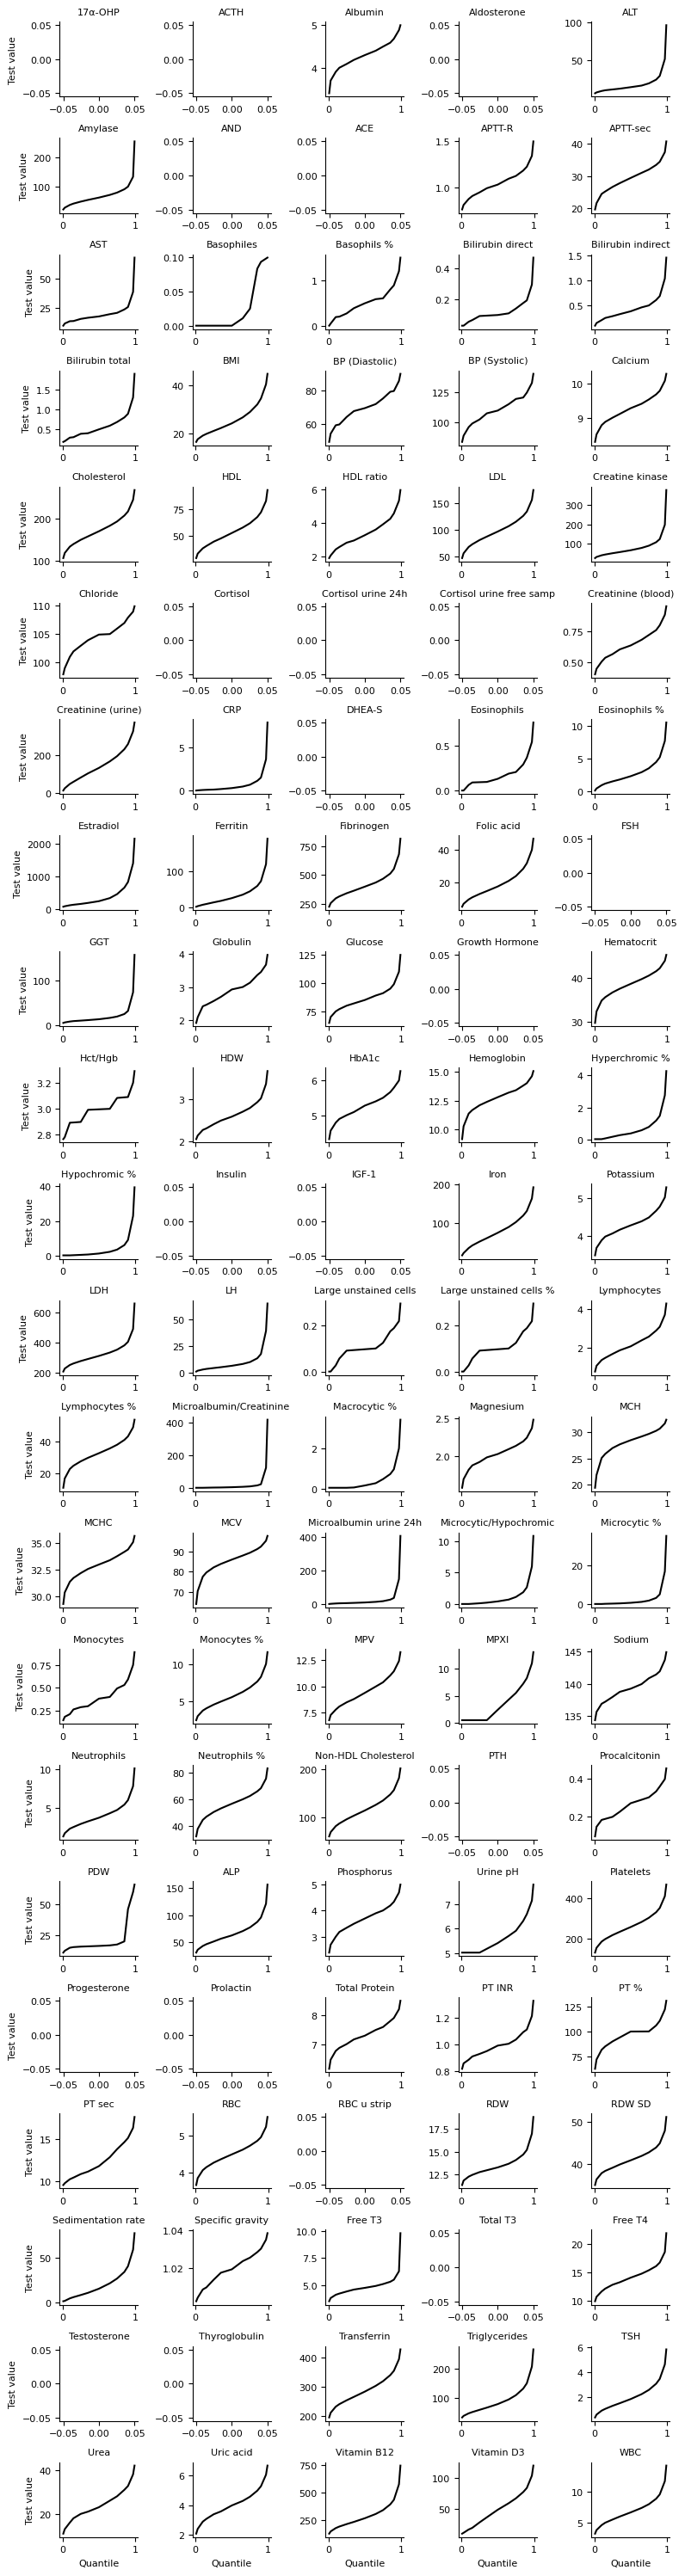

In [17]:
def plot_normlab(tests,age=30):
    nrow = 5
    plt.figure(figsize=(8,30))
    for i,test in enumerate(tqdm(tests)):
        ax  = plt.subplot(int(np.ceil(len(tests)/nrow)),nrow,i+1)
        tdf = labnorm.loc[(labnorm.age==30)&(labnorm.lab==metadata.loc[test]['LabNorm name'])].copy()
        tdf['value'].loc[tdf.value<0] = np.min(tdf['value'].loc[tdf.value>0])
        ax.plot(tdf['quantile'],tdf['value'],c='k')
        ax.set_xlabel('Quantile')
        ax.set_ylabel('Test value')
        ax.set_title(metadata.loc[test]['Nice name'])
        remove_top_right_frame([ax])
        if i<len(tests)-nrow:
            ax.set_xlabel('')
        if np.mod(i,nrow) != 0:
            ax.set_ylabel('')
    plt.tight_layout(); 
    
plot_normlab(all_tests) 
plt.savefig('S_2.pdf',bbox_inches = 'tight',dpi=300)
plt.show()

# We analyze the main trends in the dataset

In [18]:
summary = []
for test in tqdm(tests):
    temp           = get_test_data(test)
    ref            = get_age_matched_reference(test)
        
    x,v,e,n        = get_stats_from_dataset(test,'quantile',merge_timepoints=False)    
    var_q          = v.max() - v.min()
    
    x,v,e,n        = get_stats_from_dataset(test,'value_at_quantile',merge_timepoints=False)
    relative_range = (v.max() - v.min())/ np.mean(v.iloc[:20])
    
    ref_cv         = ref['sd']/ref['mean']
    summary.append([var_q,relative_range,ref_cv])
summary = pd.DataFrame(summary,columns=['quantile variation','percent change','reference CV'],index=tests)

  0%|          | 0/76 [00:00<?, ?it/s]

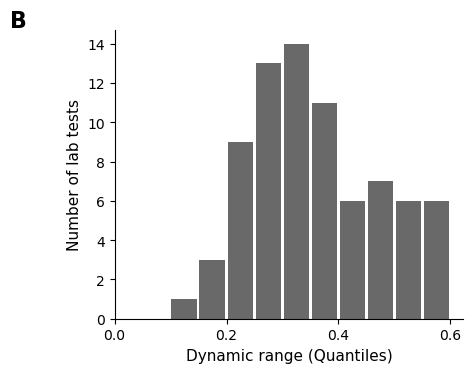

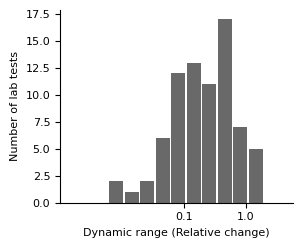

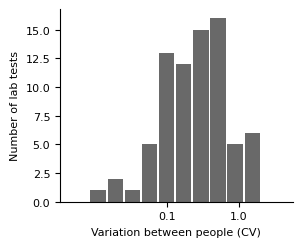

In [19]:
plt.figure(figsize=(4.5,3.75))
ax = plt.subplot(111)
summary['quantile variation'].hist(ax = ax,color='dimgray', zorder=2, rwidth=0.9)
ax.set_xlabel('Dynamic range (Quantiles)', fontsize=11)
ax.set_ylabel('Number of lab tests', fontsize=11)
ax.set_xticks([0,0.2,0.4,0.6])
for t in (ax.get_xticklabels() + ax.get_yticklabels()):
    t.set_fontsize(10)

ax.grid(False)
remove_top_right_frame([ax])
ax.annotate("B", xy=(-0.3,1.01), xycoords='axes fraction', horizontalalignment="left", fontweight="bold", fontsize=16)
plt.savefig('M_2B.pdf',dpi=300,bbox_inches = 'tight',pad_inches=0.1)
plt.savefig('M_2B.svg',dpi=300,bbox_inches = 'tight',pad_inches=0.1)
plt.show()

plt.figure(figsize=(3,2.5))
ax = plt.subplot(111)
np.log10(summary['percent change']).hist(ax = ax,color='dimgray', zorder=2, rwidth=0.9)
ax.set_xlabel('Dynamic range (Relative change)')
ax.set_ylabel('Number of lab tests')
ax.grid(False)
ax.set_xticks(np.arange(-1,4,1))
ax.set_xticklabels([str(float(10)**tick) for tick in ax.get_xticks()])
ax.set_xlim([-3,0.75])

remove_top_right_frame([ax])
# plt.savefig('percent_variation_hist.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()
plt.show()

plt.figure(figsize=(3,2.5))
ax = plt.subplot(111)
np.log10(summary['reference CV']).hist(ax = ax,color='dimgray', zorder=2, rwidth=0.9)
ax.set_xlabel('Variation between people (CV)')
ax.set_ylabel('Number of lab tests')
ax.grid(False)
ax.set_xticks(np.arange(-1,4,1))
ax.set_xticklabels([str(float(10)**tick) for tick in ax.get_xticks()])
ax.set_xlim([-2.5,0.75])

remove_top_right_frame([ax])
# plt.savefig('reference_variation_hist.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()
plt.show()

0.718823350380136 2.6292343136109955e-13


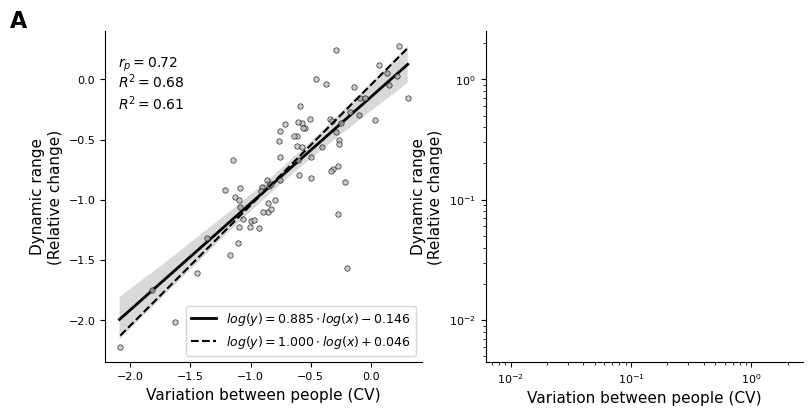

In [20]:
plt.figure(figsize=(9,7.5))
ax       = plt.subplot(121)
X,Y      = (summary.dropna()['reference CV']).values.reshape(-1, 1),(summary.dropna()['percent change']).values.reshape(-1, 1)
X, Y = np.log10(X), np.log10(Y)

reg      = LinearRegression().fit(X,Y)
text     = rf'$log(y) = {reg.coef_[0, 0]:.1f}\cdot log(x) + {str(np.round(reg.intercept_.flat[:][0],decimals=2))}$'



tdf = summary.dropna()[['reference CV', 'percent change']]
sns.regplot(ax=ax,x="reference CV", y="percent change", data=np.log10(tdf),
            scatter_kws={"s": 15,"edgecolor":'k',"linewidths":0.5,"color":'silver'},
           line_kws={"color": "k","linewidth":2,"zorder":-5})
spearman_corr, spearman_corr_p = spearmanr(tdf.to_numpy())
pearson_corr, pearsonn_corr_p = pearsonr(tdf['reference CV'], tdf['percent change'])
x = np.log10(tdf['reference CV'].to_numpy()[:, None])
y =  np.log10(tdf['percent change'].to_numpy()[:, None])
lr = LinearRegression(fit_intercept=True).fit(x,y)
r_score = lr.score(x,y)

text     = f'$r_{{p}}= {pearson_corr:.2f}$'#\n$p-value: {spearman_corr_p:.2f}$'
text_lr  = rf'$log(y) = {lr.coef_[0, 0]:.3f}\cdot log(x) {lr.intercept_[0]:+.3f}$'
ax.get_children()[1].set_label(text_lr)


ax.annotate(text,(-2.1, 0.1), fontsize=10)
ax.annotate("A", xy=(-0.3,1.01), xycoords='axes fraction', horizontalalignment="left", fontweight="bold", fontsize=16)
#ax.annotate('$r_{fit} = ' +str(pearson_r)+'$', (-2.1,-0.1), fontsize=9)#\n$p-value<10^{-19}$',(-2.1,-0.1), fontsize=9)
remove_top_right_frame([ax])
ax.set_xlabel('Variation between people (CV)', fontsize=11)
ax.set_ylabel('Dynamic range\n(Relative change)', fontsize=11)
ax.set_aspect(1)
# Points extracted with PlotDigitizer version 3.1.5
slope = (-2.1283333333333333 - 0.2558019028815669) / (-2.1283333333333333 - 0.25580190288157)
intercept = (-2.0823709959245993) - slope * (-2.1283333333333333)
ax.plot((-2.0823709959245993 ,0.30100086379546775), (-2.1283333333333333, 0.25580190288157), color="k", linestyle="--", label=rf'$log(y) = {slope:.3f}\cdot log(x) {intercept:+.3f}$')

r_score_dashed = r2_score(y, slope * x + intercept)
ax.annotate(f"$R^2={r_score:.2f}$\n$R^{{2}}={r_score_dashed:.2f}$", (-2.1, -0.25), fontsize=10)
ax.legend(loc="lower right", fontsize=9)
ax = plt.subplot(122)
ax.scatter(10 ** x, 10 ** y, color="w", edgecolor="w")
ax.set_yscale("log")
ax.set_xscale("log")

remove_top_right_frame([ax])
ax.set_xlabel('Variation between people (CV)', fontsize=11)
ax.set_ylabel('Dynamic range\n(Relative change)', fontsize=11)
ax.set_aspect(1)
# plt.savefig('M_2A_log.svg',dpi=300,bbox_inches = 'tight',pad_inches=0.1)
plt.show()

## Data normalziation and clustering using kmeans and spearman correlation - custom z-score (not included in the paper)

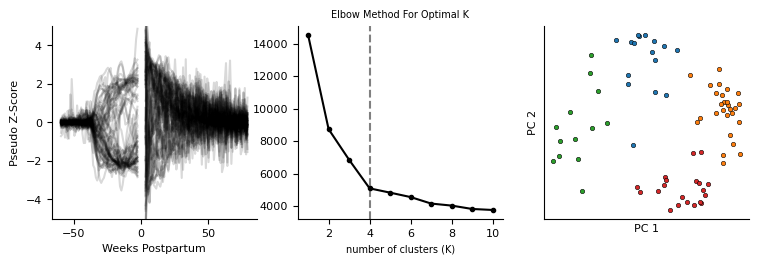

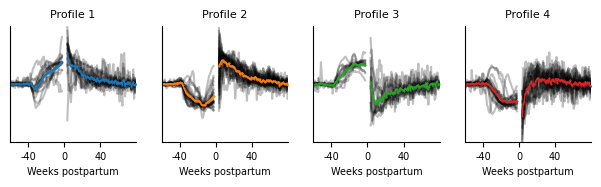

(135, 76)


In [21]:
def get_pca_curve(test,preg_period,norm_baselines=True):
    # remove timepoints around delivery
    df       = get_test_data(test)['quantile'].drop(index=[-1.5,-0.5,0.5,1.5,2.5])
    df['sd'] = df['error']*np.sqrt(df['n'])

    ## norm end to start
    mu_end   = np.sum(df.loc[70:]['n']*df.loc[70:]['value'])/(np.sum(df.loc[70:]['n']))
    sd_end   = np.sqrt(np.sum(df.loc[70:]['n']*df.loc[70:]['sd']**2)/(np.sum(df.loc[70:]['n'])))
    mu_start = np.sum(df.loc[:-50]['n']*df.loc[:-50]['value'])/(np.sum(df.loc[:-50]['n']))
    sd_start = np.sqrt(np.sum(df.loc[:-50]['n']*df.loc[:-50]['sd']**2)/(np.sum(df.loc[:-50]['n'])))  

    mu          = pd.concat([(df['value'].loc[:0] - mu_start),(df['value'].loc[0:] - mu_end)])
    err         = pd.concat([df['error'].loc[:0]             ,df['error'].loc[0:]])

    if norm_baselines:
        err.loc[0:] = err.loc[0:]/mu.loc[0:].std()
        err.loc[:0] = err.loc[:0]/mu.loc[:0].std()
        mu.loc[0:]  = mu.loc[0:]/mu.loc[0:].std()
        mu.loc[:0]  = mu.loc[:0]/mu.loc[:0].std()

    w_start, w_end = preg_period
    x   =  df.loc[w_start:w_end].index.values
    mu  =  mu.loc[w_start:w_end]
    err =  err.loc[w_start:w_end]
    return x,mu,err

zdf = pd.DataFrame([get_pca_curve(test,[-60,80])[1] for test in tests],index=tests).T.fillna(method ='backfill')
plt.figure(figsize=(9,2.5))
ax  = plt.subplot(131)
zdf.loc[:0].plot(legend=False,c='k',alpha=0.15,ax=ax)
zdf.loc[0:].plot(legend=False,c='k',alpha=0.15,ax=ax)
ax.set_xlabel('Weeks Postpartum',fontsize=8)
ax.set_ylabel('Pseudo Z-Score',fontsize=8)
ax.set_ylim([-5,5])
remove_top_right_frame([ax])

ax   = plt.subplot(132)
K    = range(1,11)
temp = np.array([KMeans(n_clusters=k).fit(zdf.to_numpy().T).inertia_ for k in K])
ax.plot(K, temp,c='k',marker='o',markersize=3)
ax.set_xlabel('number of clusters (K)',fontsize=7)
ax.set_ylabel('SSE',fontsize=7)
ax.set_title('Elbow Method For Optimal K',fontsize=7)
ax.axvline(x=4,c='gray',ls='--',zorder=-4)
ax.set_xlim([0.5,10.5])
remove_top_right_frame([ax])

n_clusters= 4
kmeans    = KMeans(n_clusters,n_init =1000).fit(zdf.to_numpy().T)
clusters  = kmeans.fit_predict(zdf.to_numpy().T)
centroids = pd.DataFrame(np.squeeze(kmeans.cluster_centers_),columns=zdf.index).T

#order clusters
clust_dict        = to_dict(np.argsort(centroids.iloc[0]),centroids.columns.values)
centroids.columns = [clust_dict[k] for k in centroids.columns]
clusters          = np.array([clust_dict[k] for k in clusters])
clust_dict        = {0: 2, 1: 0, 2: 3, 3: 1}
centroids.columns = [clust_dict[k] for k in centroids.columns]
clusters          = np.array([clust_dict[k] for k in clusters])

ax        = plt.subplot(133)
pca       = PCA(n_components=2).fit(zdf.to_numpy())
pc_scores = pd.DataFrame(pca.components_,columns=zdf.columns).T
[pc_scores.loc[np.array(tests)[clusters == i]].plot.scatter(x=0,y=1,c=def_color[i],ax=ax,s=10,edgecolor='k',linewidth=0.4) for i in range(4)]
ax.set_xticks([]); ax.set_xlabel('PC 1')
ax.set_yticks([]); ax.set_ylabel('PC 2')   
remove_top_right_frame([ax])  

plt.subplots_adjust(wspace=0.2)
plt.show()

cluster_colors = [def_color[3],def_color[3],def_color[0],def_color[0]]
plt.figure(figsize=(7.5,1.5))
for i in range(n_clusters):
    ax = plt.subplot(1,4,i+1)

    zdf.T.loc[clusters==i].T.loc[:0].plot(legend=False,ax=ax,c='k',alpha=0.25)
    zdf.T.loc[clusters==i].T.loc[0:].plot(legend=False,ax=ax,c='k',alpha=0.25)

    centroids[i].loc[:0].plot(c=def_color[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)
    centroids[i].loc[0:].plot(c=def_color[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)

    ax.set_xlabel('Weeks postpartum',fontsize=7)
    ax.set_xlim([-60,80])
    ax.set_yticks([])
    ax.set_ylim([-6,6])
    ax.set_xticks(np.arange(-40,80,40),np.arange(-40,80,40),fontsize=7)
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    remove_top_right_frame([ax])
            
plt.subplots_adjust(wspace=0.2)
plt.show()

## A 5th 'Outliers' cluster

['AMYLASE_BLOOD' 'Cl' 'FOLIC_ACID' 'GLOBULIN' 'GLUCOSE_BLOOD' 'IRON'
 'MAGNESIUM_BLOOD' 'MPV']


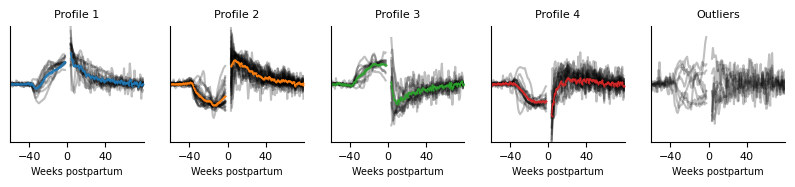

In [22]:
cluster_centers = kmeans.cluster_centers_
X               = zdf.to_numpy().T
distances       = np.linalg.norm(X[:, np.newaxis] - cluster_centers, axis=2)
outliers        = np.where(np.all(distances > np.percentile(distances.min(axis=1),90), axis=1))
clusters[outliers] = 4

plt.figure(figsize=(10,1.5))
for i in range(n_clusters+1):
    ax = plt.subplot(1,5,i+1)

    zdf.T.loc[clusters==i].T.loc[:0].plot(legend=False,ax=ax,c='k',alpha=0.25)
    zdf.T.loc[clusters==i].T.loc[0:].plot(legend=False,ax=ax,c='k',alpha=0.25)

    if i < 4:
        centroids[i].loc[:0].plot(c=def_color[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)
        centroids[i].loc[0:].plot(c=def_color[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)

    ax.set_xlabel('Weeks postpartum',fontsize=7)
    ax.set_xlim([-60,80])
    ax.set_yticks([])
    ax.set_ylim([-6,6])
    ax.set_xticks(np.arange(-40,80,40))
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    remove_top_right_frame([ax])

ax.set_title('Outliers')    
plt.subplots_adjust(wspace=0.2)
plt.show()

### Try to cluster by the best affine function (didn't work)

In [23]:
def affine_regress(test1, test2, plot_large_p_val=0.):
    # Find the affine transformation with best results from test2 to test1
    q_test1 = get_stats_from_dataset(test1, "quantile", merge_timepoints=False)[1]
    q_test2 = get_stats_from_dataset(test2, "quantile", merge_timepoints=False)[1]
    res = linregress(q_test2, q_test1, "greater")
    if plot_large_p_val and (res.pvalue > plot_large_p_val or res.slope < 0):
        plt.plot(q_test2 * res.slope + res.intercept, "r")
        plt.plot(q_test2, "g")
        plt.plot(q_test1, "b")
        plt.annotate(f"P-value:{res.pvalue:.5f}, slope:{res.slope:.2f}", xycoords='figure fraction', xy=(0.8,0.8), ha="right")
        plt.annotate(f"{test1}, {test2}", xycoords='figure fraction', xy=(0.8,0.78), ha="right")
        plt.show()
    return res.slope, res.intercept, res.pvalue


def affine_regress_qp_solver(test1, test2):
    q_test1 = get_stats_from_dataset(test1, "quantile", merge_timepoints=False)[1]
    q_test2 = get_stats_from_dataset(test2, "quantile", merge_timepoints=False)[1]
    # optimize sum(test1_i - slope*test2_i - intercept)**2 where slope>0
    # Removing constants optimize sum((slope*test2_i)**2) + intercept**2 + sum(2*slope*intercept*test2_i) - 2*slope*sum(test1_i*test2_i) -2*sum(test2_i)*intercept
    cost_pd_mat = np.array((((q_test2 ** 2).sum(), q_test2.sum()),(q_test2.sum(), len(q_test2)))) * 2
    cost_vec = np.array((-2*(q_test1 * q_test2).sum(), -2 * q_test1.sum()))
    lower_bound_vec = np.array((0, -np.inf), dtype=float)
    return solve_qp(P=cost_pd_mat, q=cost_vec, lb=lower_bound_vec, solver="cvxopt")
    

def calc_pearsonr_best_affine_all_tests(tests_quantile_df):
    cols = tests_quantile_df.columns
    affine_pearson = pd.DataFrame(np.empty((len(cols), len(cols)), dtype=float),
                                  columns=cols, index=cols)
    for i in trange(len(cols)):
        test1 = cols[i]
        for j in range(i, len(cols)):
            test2 = cols[j]
            lin_res = affine_regress_qp_solver(test1, test2)
            p = pearsonr(tests_quantile_df[test1], lin_res[0] * tests_quantile_df[test2] + lin_res[1]).statistic
            affine_pearson.loc[test1, test2] = p
            affine_pearson.loc[test2, test1] = p
            # flip = np.random.binomial(1, 10/30000)
            # if flip:
            #     plt.plot(get_stats_from_dataset(test2, "quantile", merge_timepoints=False)[1] * lin_res[0] + lin_res[1], "r")
            #     plt.plot(get_stats_from_dataset(test2, "quantile", merge_timepoints=False)[1], "g")
            #     plt.plot(get_stats_from_dataset(test1, "quantile", merge_timepoints=False)[1], "b")
            #     plt.annotate(f"slope:{lin_res[0]:.2f}", xycoords='figure fraction', xy=(0.8,0.8), ha="right")
            #     plt.annotate(f"{test1}, {test2}", xycoords='figure fraction', xy=(0.8,0.78), ha="right")
            #     plt.show()
    return affine_pearson
        

  0%|          | 0/76 [00:00<?, ?it/s]

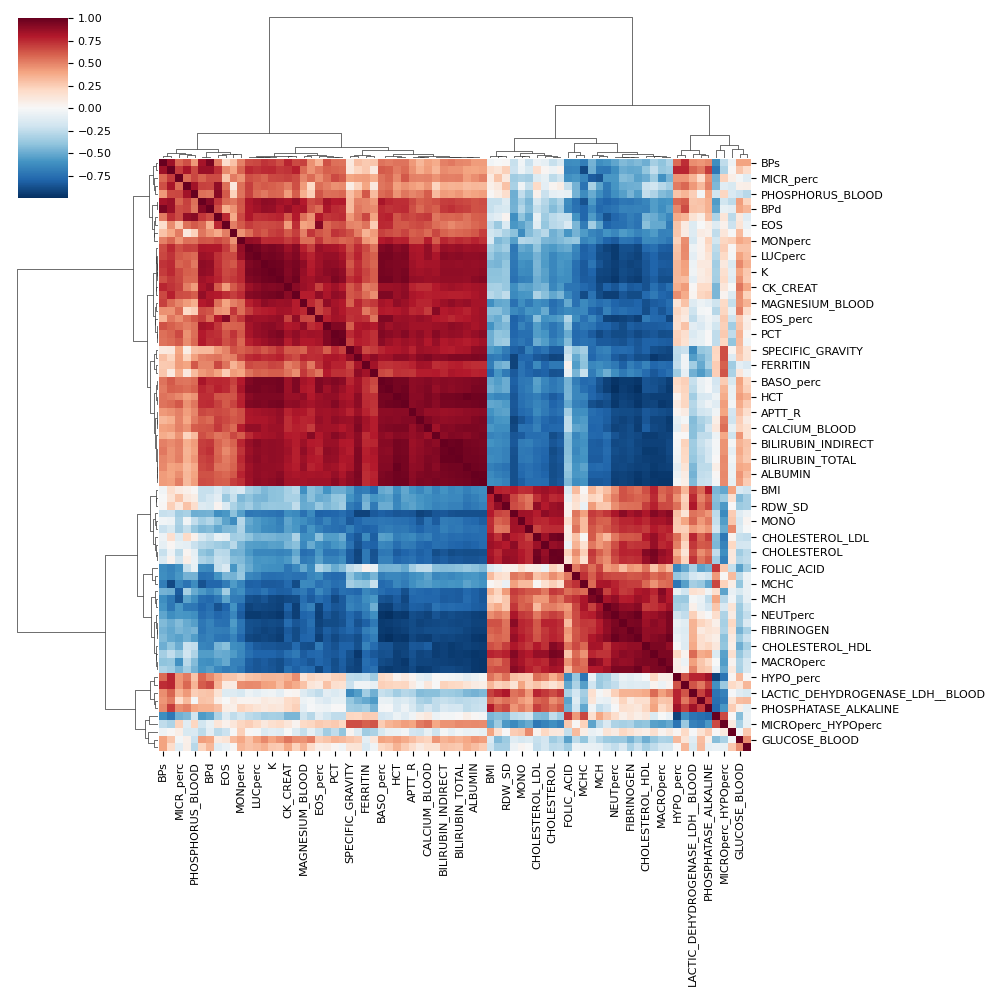

In [24]:
tests_full_name_quantile_score = pd.DataFrame([get_quantile_stats(test)["value"].rename(metadata.loc[test].name) for test in tests]).T
affine_pearson = calc_pearsonr_best_affine_all_tests(tests_full_name_quantile_score)
sns.clustermap(affine_pearson,method='ward',metric='euclidean',cmap='RdBu_r',center=0,figsize=(10,10),row_cluster=True,col_cluster=True)

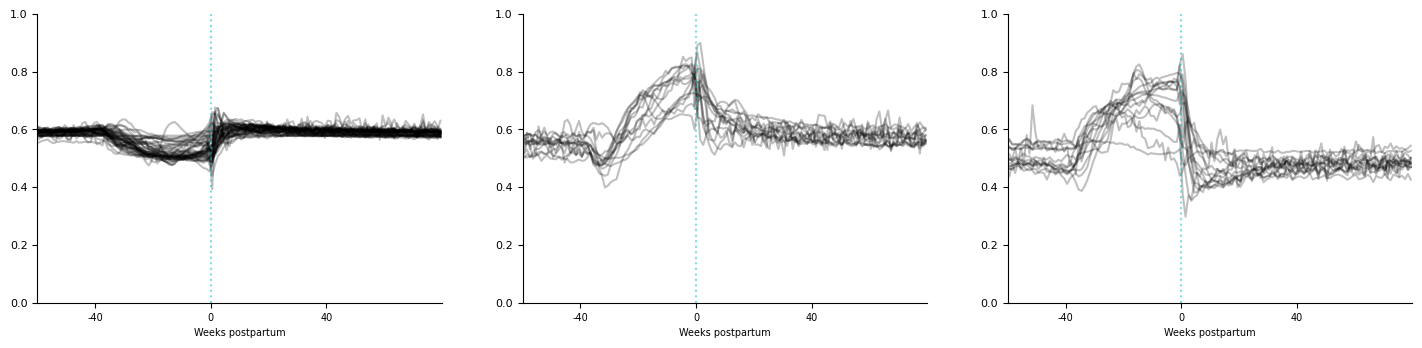

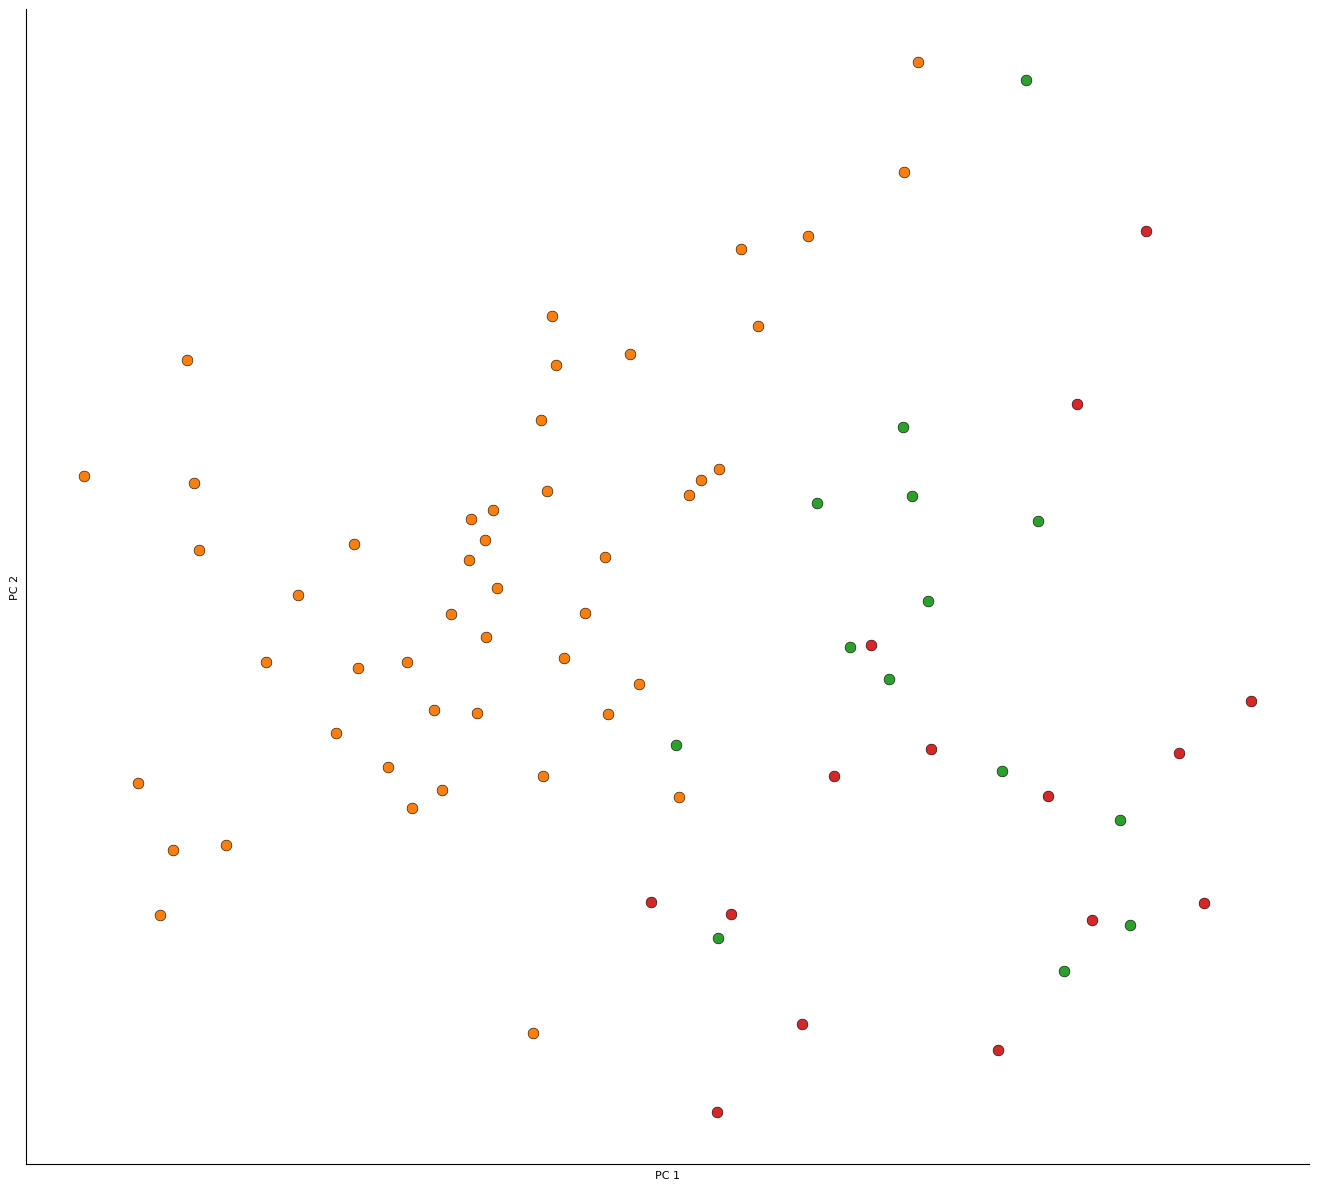

In [25]:
plt_rc_param_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [24,15]
linkage_affine_pearson = linkage(squareform(1 - affine_pearson.to_numpy(), checks=False), method="ward")
clusters_affine_pearson = pd.Series(fcluster(linkage_affine_pearson, 3, criterion="maxclust"), index=tests_full_name_quantile_score.columns, name="cluster")
for i in clusters_affine_pearson.unique():
    ax = plt.subplot(1,max(clusters_affine_pearson.unique()) + 1,i)
    clust_i = pd.DataFrame(tests_full_name_quantile_score, index=tests_full_name_quantile_score.index, columns=tests_full_name_quantile_score.columns).T[clusters_affine_pearson == i]
    rep = clust_i.sample().index[0]
    for test in clust_i.index:
        coef = affine_regress_qp_solver(rep, test)
        ax.plot(clust_i.loc[test] * coef[0] + coef[1],c='k',alpha=0.25)
    # center_i = clust_i.mean()
    # center_i.plot(c=def_color[i],ax=ax,title = 'Profile ' + str(i),marker='o',markersize=0,lw=2)
    ax.set_xlabel('Weeks postpartum',fontsize=7)
    ax.set_xlim([-60,80])
    # ax.set_yticks([])
    ax.set_ylim([0,1])
    ax.set_xticks(np.arange(-40,80,40),np.arange(-40,80,40),fontsize=7)
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    ax.axvline(0, linestyle="dotted", alpha=0.5, c="c")
    ax.set_aspect(100)
    remove_top_right_frame([ax])

plt.show()
plt.clf()

ax        = plt.subplot(111)
pca_transform       = PCA(n_components=2).fit_transform(tests_full_name_quantile_score.T)
pc_scores = pd.DataFrame(pca_transform.T,columns=tests_full_name_quantile_score.columns).T
for i in clusters_affine_pearson.unique():
    pc_scores.loc[np.array(tests_full_name_quantile_score.columns)[clusters_affine_pearson == i ]].plot.scatter(x=0,y=1,c=def_color[i],ax=ax,s=60,edgecolor='k',linewidth=0.4)
ax.set_xticks([]); ax.set_xlabel('PC 1')
ax.set_yticks([]); ax.set_ylabel('PC 2')   
ax.set_aspect(2)
remove_top_right_frame([ax])  

plt.subplots_adjust(wspace=0.2)
plt.show()

plt.rcParams['figure.figsize'] = plt_rc_param_figsize

## IFFL model for the clusters:

In [27]:
ax,bx,ay,by,t = symbols('b,a,d,c,t',positive=True)

x       = Function('x')(t)
y       = Function('y')(t)
u       = Function('u')(t)
dx      = u*bx   - ax*x
dy      = u*by/x - ay*y
deqx    = Eq(Derivative(x),dx)
deqy    = Eq(Derivative(y),dy)
Matrix([deqx,deqy])

⎡d                         ⎤
⎢──(x(t)) = a⋅u(t) - b⋅x(t)⎥
⎢dt                        ⎥
⎢                          ⎥
⎢d          c⋅u(t)         ⎥
⎢──(y(t)) = ────── - d⋅y(t)⎥
⎣dt          x(t)          ⎦

We solve the model assuming $y$ dynamics are much faster than $x$. 

We solve the quasi steady state of $y$

In [28]:
yqst = solve(dy,y)[0]
Eq(y,yqst)

The steady state of the model (when $u(t)$ is constant) is:

In [29]:
xst = solve(dx,x)[0]
Eq(x,xst),Eq(y,yqst.subs(x,xst))

During pregnancy, there is a load on $x$ and $y$, modeled by increasing production rate

In [30]:
m = symbols('m',positive=True)
load = (1+m*t)
deqx.subs(u,load)

The time-dependend solution for $x(t)$ is:

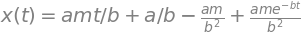

In [31]:
x_pregnancy = dsolve(deqx.subs(u,load),ics={x.subs(t,0):xst.subs(u,1)}).args[1]
Eq(x,x_pregnancy)

And thus for $y$ (assuming quasi steady state)

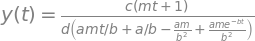

In [32]:
y_pregnancy = yqst.subs(u,load).subs(x,x_pregnancy)
Eq(y,y_pregnancy)

Note that for large $t$, $x$ grows in proportion to the load:

In [33]:
Eq(x,x_pregnancy.series(x=t,x0=oo,n=0))

And $y$ is compenstated - it doesn't grow indefintly, but rather reaches a steady state

In [34]:
Eq(y,yqst.subs(u,load).subs(x,x_pregnancy.series(x=t,x0=oo,n=0).removeO()).limit(t,oo))

Following 38 weeks of gestation: the values of $x$ and $y$ at delivery ($x_d, y_d$)

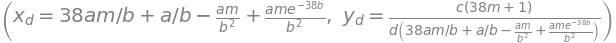

In [35]:
x_d = symbols('x_d')
y_d = symbols('y_d')
Eq(x_d,x_pregnancy.subs(t,38)),Eq(y_d,y_pregnancy.subs(t,38))

Postpartum, $x$ decay to its original steady state:

In [36]:
x_postpartum = dsolve(deqx.subs(u,1),ics={x.subs(t,0):x_d}).args[1]
x_postpartum_full = x_postpartum.subs(x_d,x_pregnancy.subs(t,38))

Eq(x,x_postpartum)

In [37]:
y_postpartum =yqst.subs(u,1).subs(x,x_postpartum)
y_postpartum_full = y_postpartum.subs(x_d,y_pregnancy.subs(t,38))
Eq(y,y_postpartum)

In [38]:
pregnancy_func    = lambdify([t,ax,bx,ay,by,m],[x_pregnancy,y_pregnancy,load])
postpartum_func   = lambdify([t,ax,bx,ay,by,m],[x_postpartum_full,y_postpartum_full,1])
pregnancy_period  = np.arange(-22,38,1); pregnancy_period[pregnancy_period<0] = 0
postpartum_period = np.arange(0,80,1)

def IFFL_analytic_sol(pars):
    nx_preg,ny_preg,nload_preg = pregnancy_func(pregnancy_period,*pars)
    nx_pp,ny_pp,nload_pp       = postpartum_func(postpartum_period,*pars)
    numeric_x                  = np.append(nx_preg,nx_pp)
    numeric_y                  = np.append(ny_preg,ny_pp)
    numeric_load               = np.append(nload_preg,nload_pp)
    return numeric_x, numeric_y,numeric_load

pars  = [0.05,0.05,1,1,0.01]
res   = pd.DataFrame(IFFL_analytic_sol(pars),columns=np.arange(-60,80),index=['x','y','load']).T.fillna(1)

In [39]:
#.drop(index=[-2.5, -1.5, -0.5,0.5,1.5,2.5])
tests_quantile_df = pd.DataFrame([get_quantile_stats(test)["value"].rename(metadata.loc[test]["Short name"]) for test in tests]).T
#rank_quantile_df = pd.DataFrame(rankdata(tests_quantile_df, axis=0), columns=tests_quantile_df.columns, index=tests_quantile_df.index)
spearman_stat, spearman_p = spearmanr(tests_quantile_df)
# pearson_stat = tests_quantile_df.corr(method='pearson')
# pearson_stat_df = pd.DataFrame(pearson_stat, index=tests_quantile_df.columns, columns=tests_quantile_df.columns)
spearman_stat_df = pd.DataFrame(spearman_stat, index=tests_quantile_df.columns, columns=tests_quantile_df.columns)
distance_matrix = squareform(1 - spearman_stat)
linkage_spearman = linkage(distance_matrix, method="ward")
clusters_spearman_colors = pd.Series(fcluster(linkage_spearman, 4, criterion="maxclust"), index=tests_quantile_df.columns, name="cluster").map({1: "green", 2: "orange", 3: "cyan", 4: "magenta"})

# sns.clustermap(pearson_stat_df,method='ward',metric='euclidean',cmap='RdBu_r',center=0,figsize=(10,10),row_cluster=True,col_cluster=True)

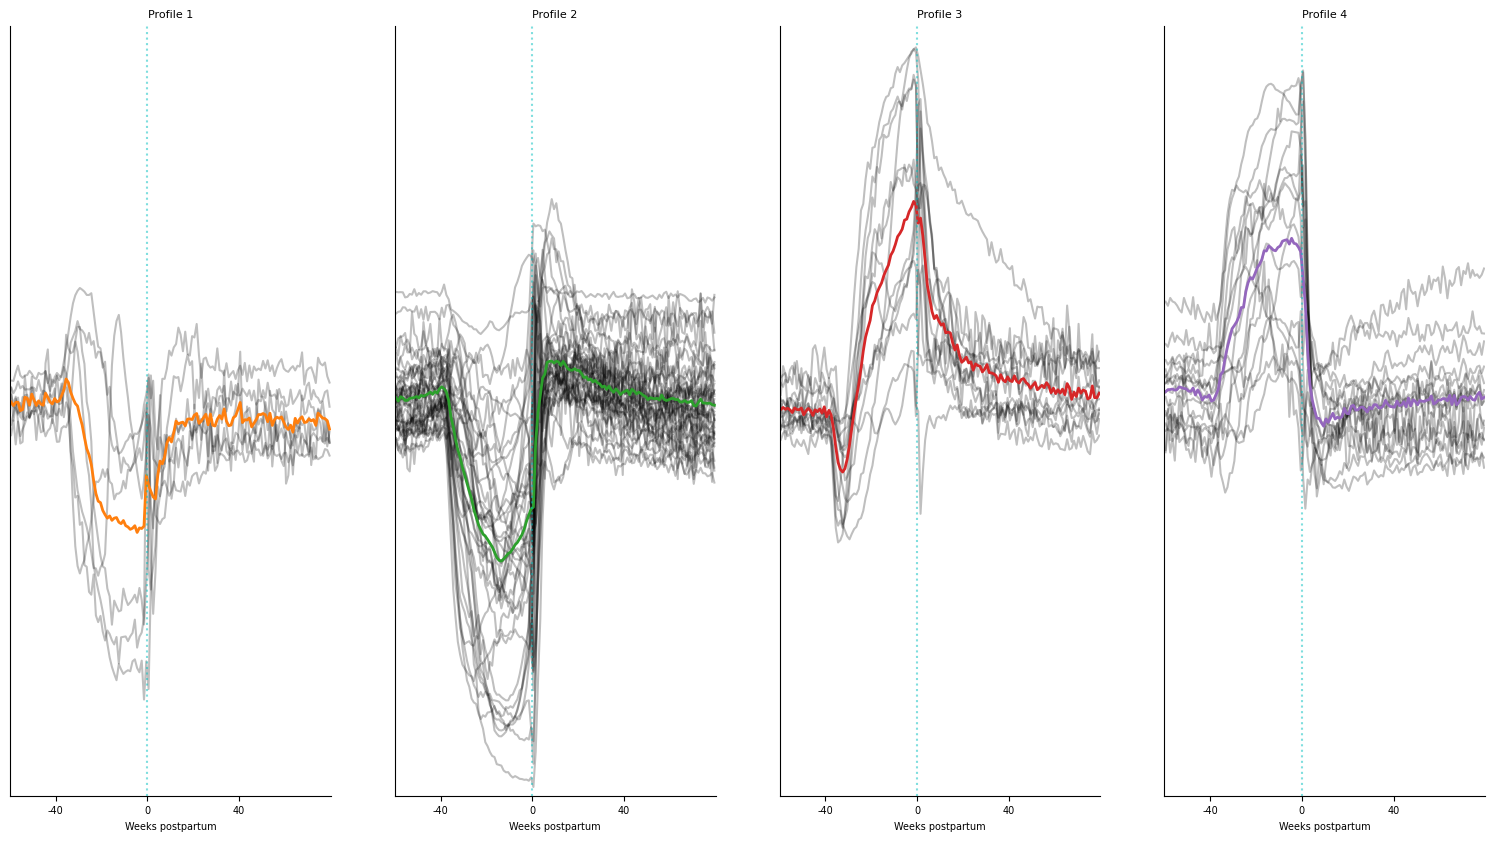

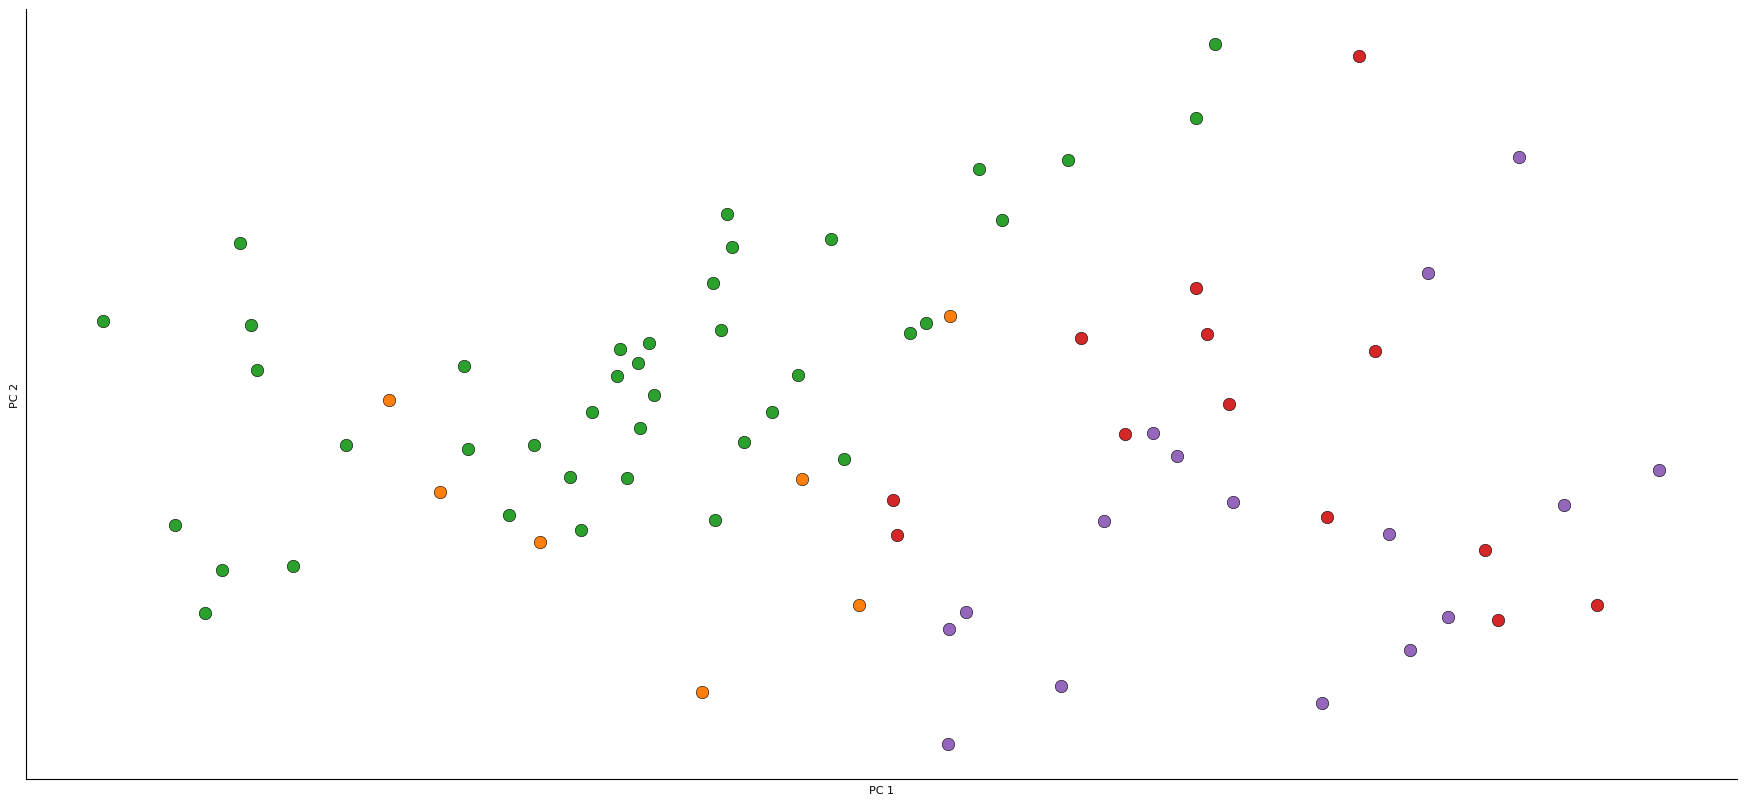

In [40]:
plt_rc_param_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [24,10]
linkage_spearman = linkage(squareform(1 - spearman_stat), method="ward")
clusters_spearman = pd.Series(fcluster(linkage_spearman, 4, criterion="maxclust"), index=tests_quantile_df.columns, name="cluster")
for i in clusters_spearman.unique():
    ax = plt.subplot(1,max(clusters_spearman.unique()) + 1,i)
    clust_i = tests_quantile_df.T[clusters_spearman == i]
    clust_i.T.plot(legend=False,ax=ax,c='k',alpha=0.25)
    center_i = clust_i.mean()
    center_i.plot(c=def_color[i],ax=ax,title = 'Profile ' + str(i),marker='o',markersize=0,lw=2)
    ax.set_xlabel('Weeks postpartum',fontsize=7)
    ax.set_xlim([-60,80])
    ax.set_yticks([])
    ax.set_ylim([0,1])
    ax.set_xticks(np.arange(-40,80,40),np.arange(-40,80,40),fontsize=7)
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    ax.axvline(0, linestyle="dotted", alpha=0.5, c="c")
    remove_top_right_frame([ax])

plt.show()
plt.clf()

ax        = plt.subplot(111)
pca_tranformed       = PCA(n_components=2).fit_transform(tests_quantile_df.to_numpy().T)
tsne_transformed       = TSNE(n_components=2).fit_transform(tests_quantile_df.to_numpy().T)
pc_scores = pd.DataFrame(pca_tranformed.T,columns=tests_quantile_df.columns).T
tsne_scores = pd.DataFrame(tsne_transformed.T,columns=tests_quantile_df.columns).T
for i in clusters_spearman.unique():
    pc_scores.loc[np.array(tests_quantile_df.columns)[clusters_spearman == i ]].plot.scatter(x=0,y=1,c=def_color[i],ax=ax,s=80,edgecolor='k',linewidth=0.4)
ax.set_xticks([]); ax.set_xlabel('PC 1')
ax.set_yticks([]); ax.set_ylabel('PC 2')   
ax.set_aspect(1)
remove_top_right_frame([ax])  

plt.subplots_adjust(wspace=0.2)
plt.show()

plt.rcParams['figure.figsize'] = plt_rc_param_figsize

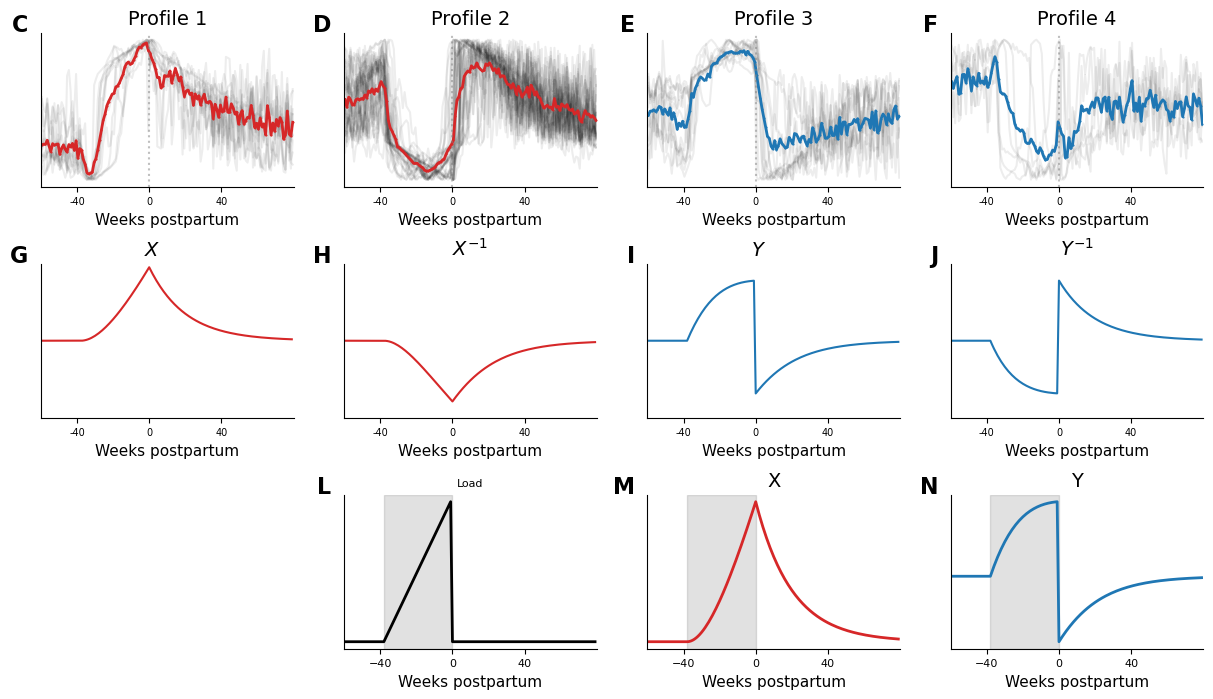

In [41]:
order_spearman_clusts = (4, 2, 1, 3)
plt.figure(figsize=(15,8))
profiles_panels = ("C", "D", "E", "F")
outlier_tests = []
for i in clusters_spearman.unique():
    index_subplot = order_spearman_clusts[i - 1]
    color = def_color[3] if index_subplot <= 2 else def_color[0]
    ax = plt.subplot(3,4, index_subplot)

    clust_i = pd.DataFrame(rankdata(tests_quantile_df, axis=0), index=tests_quantile_df.index, columns=tests_quantile_df.columns).T[clusters_spearman == i]
    #clust_i.T.plot(legend=False,ax=ax,c='k',alpha=0.08)
    mean_clust_i = clust_i.mean(axis=0)
    dist_from_mean = ((clust_i - mean_clust_i) ** 2).sum(axis=1)
    outliers = dist_from_mean >= dist_from_mean.mean() + dist_from_mean.var() ** 0.5
    clust_i[~outliers].T.plot(legend=False,ax=ax,c='k',alpha=0.07)
    mean_clust_i.plot(c=color,ax=ax, marker='o',markersize=0.5,lw=2, fontsize=14)
    ax.annotate(profiles_panels[index_subplot - 1], xy=(-0.05,1.01), xycoords='axes fraction', horizontalalignment="right", fontweight="bold", fontsize=16)
    ax.set_title('Profile ' + str(index_subplot), fontsize=14)
    ax.set_xlabel('Weeks postpartum',fontsize=11)
    ax.set_xlim([-60,80])
    ax.set_yticks([])
    #ax.set_ylim([0,1])
    ax.axvline(0, linestyle="dotted", alpha=0.5, c="gray")
    ax.set_xticks(np.arange(-40,80,40),np.arange(-40,80,40),fontsize=7)
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    remove_top_right_frame([ax])
    outlier_tests += list(clust_i.index[outliers].values)
    
ax1,ax2,ax3,ax4 = plt.subplot(345),plt.subplot(346),plt.subplot(347),plt.subplot(348)
res['x']           .plot(ax=ax1,c=def_color[3])              
(1/res['x'])       .plot(ax=ax2,c=def_color[3])          
res['y']           .plot(ax=ax3,c=def_color[0])              
(1/res['y'])       .plot(ax=ax4,c=def_color[0])         

remove_top_right_frame([ax1,ax2,ax3,ax4])
[ax.set_yticks([]) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xlabel('Weeks postpartum',fontsize=11) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xlim([-60,80]) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xticks(np.arange(-40,80,40), np.arange(-40,80,40), fontsize=7) for ax in [ax1,ax2,ax3,ax4]]

ax1.set_ylim([1-0.22,1+0.22])
ax1.annotate("G", xy=(-0.05,1.01), xycoords='axes fraction', horizontalalignment="right", fontweight="bold", fontsize=16)
ax2.set_ylim([1-0.22,1+0.22])
ax2.annotate("H", xy=(-0.05,1.01), xycoords='axes fraction', horizontalalignment="right", fontweight="bold", fontsize=16)
ax3.set_ylim([1-0.18,1+0.18])
ax3.annotate("I", xy=(-0.05,1.01), xycoords='axes fraction', horizontalalignment="right", fontweight="bold", fontsize=16)
ax4.set_ylim([1-0.18,1+0.18])
ax4.annotate("J", xy=(-0.05,1.01), xycoords='axes fraction', horizontalalignment="right", fontweight="bold", fontsize=16)

ax1.set_title('$X$',fontsize=14, x=0.44)
ax2.set_title('$X^{-1}$',fontsize=14)
ax3.set_title('$Y$',fontsize=14, x=0.44)
ax4.set_title('$Y^{-1}$',fontsize=14)

ax1,ax2,ax3 = plt.subplot(3,4,10),plt.subplot(3,4,11),plt.subplot(3,4,12)
res.load.plot(ax=ax1,c='k',lw=2)
res.x.plot(ax=ax2,c=def_color[3],lw=2)
res.y.plot(ax=ax3,c=def_color[0],lw=2)

for ax in [ax1,ax2,ax3]:
    ax.set_xlim([-60,80])
    ax.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20)
    ax.set_yticks([])
    ax.set_xticks([])
    remove_top_right_frame([ax])

ax1.set_title('Load')
ax1.annotate("L", xy=(-0.05,1.01), xycoords='axes fraction', horizontalalignment="right", fontweight="bold", fontsize=16)
ax2.set_title('X', fontsize=14)
ax2.annotate("M", xy=(-0.05,1.01), xycoords='axes fraction', horizontalalignment="right", fontweight="bold", fontsize=16)
ax3.set_title('Y', fontsize=14)
ax3.annotate("N", xy=(-0.05,1.01), xycoords='axes fraction', horizontalalignment="right", fontweight="bold", fontsize=16)
[ax.set_xticks(np.arange(-40,80,40)) for ax in [ax1,ax2,ax3]]
[ax.set_xlabel('Weeks postpartum', fontsize=11) for ax in [ax1,ax2,ax3]]

plt.subplots_adjust(hspace=0.5,wspace=0.2)
# plt.savefig('M_2_spearman.svg',dpi=300,bbox_inches = 'tight',pad_inches=0.1); plt.show()
plt.show()

['BILID', 'FER', 'GLB', 'LUC', 'PT-INR', 'PT-sec', 'FA', 'MONO', 'PDW', 'TRSF', 'MPV', 'Micro:Hypo']


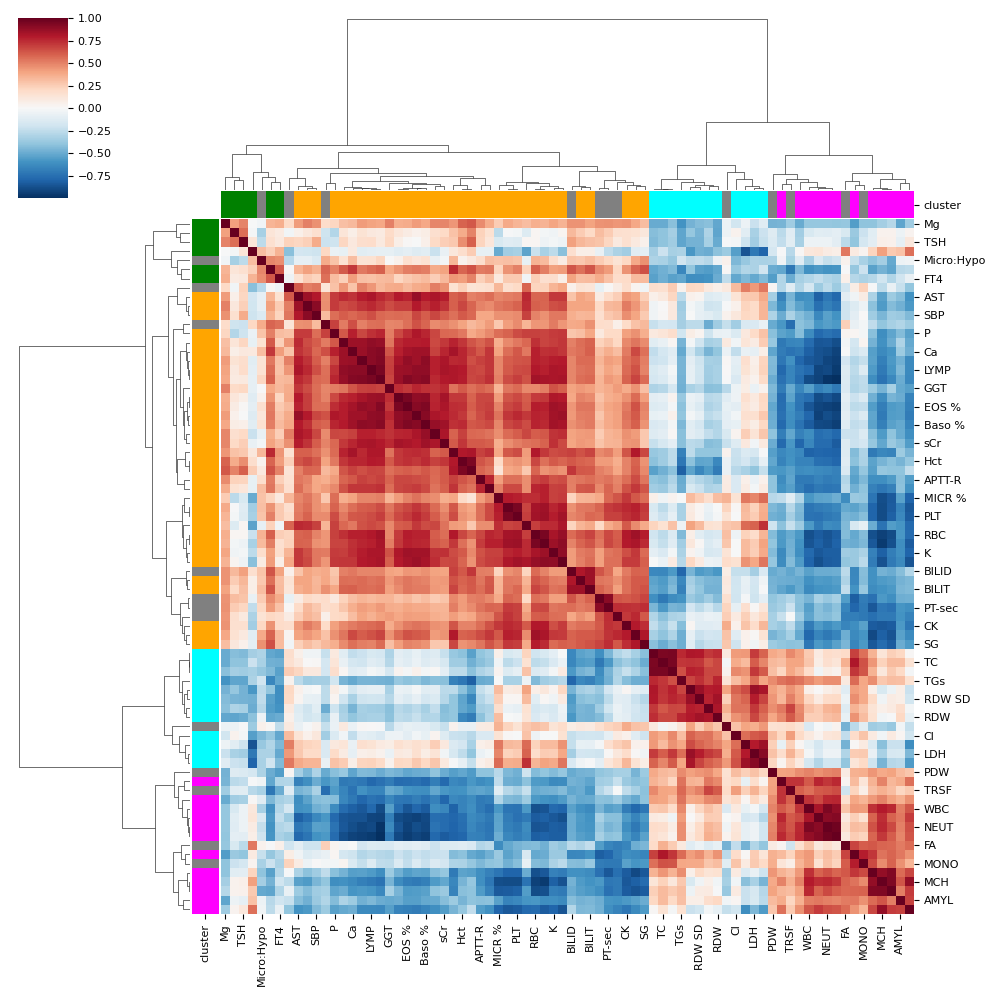

In [42]:
clusters_spearman_colors[outlier_tests] = "grey"
print(outlier_tests)
clustermap = sns.clustermap(spearman_stat_df, row_linkage=linkage_spearman, col_linkage=linkage_spearman, cmap='RdBu_r',center=0,figsize=(10,10), row_colors=clusters_spearman_colors, col_colors=clusters_spearman_colors)
clustermap.savefig('SI_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

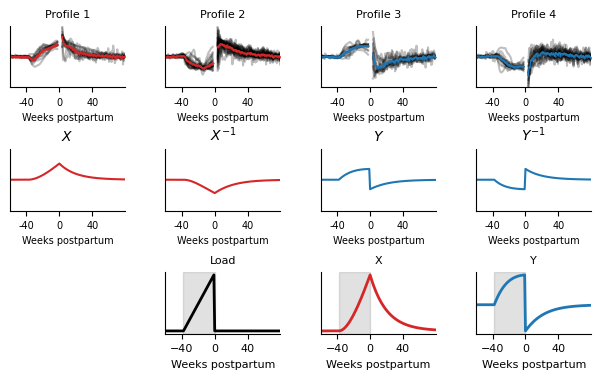

In [43]:
plt.figure(figsize=(7.5,4))
for i in range(n_clusters):
    ax = plt.subplot(3,4,i+1)

    zdf.T.loc[clusters==i].T.loc[:0].plot(legend=False,ax=ax,c='k',alpha=0.25)
    zdf.T.loc[clusters==i].T.loc[0:].plot(legend=False,ax=ax,c='k',alpha=0.25)

    zdf.T.loc[clusters==i].T.mean(axis=1).loc[:0].plot(c=cluster_colors[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)
    zdf.T.loc[clusters==i].T.mean(axis=1).loc[0:].plot(c=cluster_colors[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)
    ax.set_xlabel('Weeks postpartum',fontsize=7)
    ax.set_xlim([-60,80])
    ax.set_yticks([])
    ax.set_ylim([-6,6])
    ax.set_xticks(np.arange(-40,80,40),np.arange(-40,80,40),fontsize=7)
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    remove_top_right_frame([ax])
    
ax1,ax2,ax3,ax4 = plt.subplot(345),plt.subplot(346),plt.subplot(347),plt.subplot(348)
res['x']           .plot(ax=ax1,c=cluster_colors[0])              
(1/res['x'])       .plot(ax=ax2,c=cluster_colors[1])          
res['y']           .plot(ax=ax3,c=cluster_colors[2])              
(1/res['y'])       .plot(ax=ax4,c=cluster_colors[3])         

remove_top_right_frame([ax1,ax2,ax3,ax4])
[ax.set_yticks([]) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xlabel('Weeks postpartum',fontsize=7) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xlim([-60,80]) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xticks(np.arange(-40,80,40), np.arange(-40,80,40), fontsize=7) for ax in [ax1,ax2,ax3,ax4]]

ax1.set_ylim([1-0.4,1+0.4])
ax2.set_ylim([1-0.4,1+0.4])
ax3.set_ylim([1-0.4,1+0.4])
ax4.set_ylim([1-0.4,1+0.4])

ax1.set_title('$X$',fontsize=10)
ax2.set_title('$X^{-1}$',fontsize=10)
ax3.set_title('$Y$',fontsize=10)
ax4.set_title('$Y^{-1}$',fontsize=10)

ax1,ax2,ax3 = plt.subplot(3,4,10),plt.subplot(3,4,11),plt.subplot(3,4,12)
res.load.plot(ax=ax1,c='k',lw=2)
res.x.plot(ax=ax2,c=def_color[3],lw=2)
res.y.plot(ax=ax3,c=def_color[0],lw=2)

for ax in [ax1,ax2,ax3]:
    ax.set_xlim([-60,80])
    ax.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20)
    ax.set_yticks([])
    ax.set_xticks([])
    remove_top_right_frame([ax])

ax1.set_title('Load')
ax2.set_title('X')
ax3.set_title('Y')
[ax.set_xticks(np.arange(-40,80,40)) for ax in [ax1,ax2,ax3]]
[ax.set_xlabel('Weeks postpartum') for ax in [ax1,ax2,ax3]]

plt.subplots_adjust(hspace=1,wspace=0.35)
plt.savefig('M_2.pdf',dpi=300,bbox_inches = 'tight',pad_inches=0.1); plt.show()
plt.show()

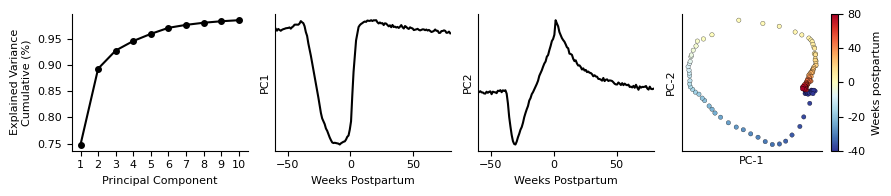

In [44]:
def scale_weeks(weeks): ## define coloarmap
    temp           = weeks.copy()
    temp[temp < 0] = temp[temp < 0]/38
    temp[temp > 0] = temp[temp > 0]/80
    return temp

minima = -1
maxima = 1
norm   = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdYlBu_r)


tdf            = pd.DataFrame([get_test_data(test)['quantile']['value'] for test in tests],index=tests).fillna(method ='backfill').T
pca            = PCA(); pca.fit(tdf)
explained_var  = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
pcomps         = pd.DataFrame(data = pca.fit_transform(tdf.to_numpy()),index=tdf.index)
pcolors        = scale_weeks(tdf.index.to_numpy())


plt.figure(figsize=(9,2))
ax  = plt.subplot(141)
ax.plot(range(1, len(explained_var[:10]) + 1), cumulative_var[:10],marker='o',c='k',markersize=4)

ax.set_xticks(range(1, len(explained_var) + 1))
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance\nCumulative (%)')
ax.set_xlim([0.5,10.5])
remove_top_right_frame([ax])


## plot
ax   = plt.subplot(142)
pcomps[0].plot(ax=ax,ylabel='PC1',c='k')
remove_top_right_frame([ax])
ax.set_xlim([-60,80])
ax.set_xlabel('Weeks Postpartum')
ax.set_yticks([])

ax   = plt.subplot(143)
pcomps[1].plot(ax=ax,ylabel='PC2',c='k')
remove_top_right_frame([ax])
ax.set_xlim([-60,80])
ax.set_xlabel('Weeks Postpartum')
ax.set_yticks([])

ax   = plt.subplot(144)
scat = ax.scatter(pcomps[0],pcomps[1],c=mapper.to_rgba(pcolors),s=10,edgecolor='k',lw=0.2)
ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
remove_top_right_frame([ax])
cbar = plt.colorbar(mapper,ax=ax,label="Weeks postpartum")
cbar.set_ticks([-1,-0.5,0,0.5,1])
cbar.set_ticklabels([-40,-20,0,40,80])
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

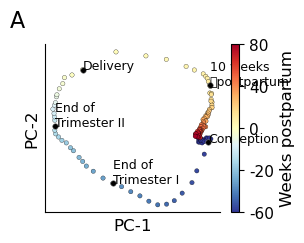

In [45]:
def annotate_point(week,projections,ax,label=None):
    if label is None:
        label= str(week)
    x_,y_ = projections.loc[week + 0.5].to_numpy()
    ax.text(x_,y_,label,alpha=0.99, fontsize=9)
    ax.scatter(x_,y_,s=16,c='k', edgecolor='gray', linewidth=0.4)


plt.figure(figsize=(3.1,2.5))
ax   = plt.subplot(111)
scat = ax.scatter(pcomps[0],pcomps[1],c=mapper.to_rgba(pcolors),s=10,edgecolor='k',lw=0.2)
ax.set_xlabel('PC-1', fontsize=12)
ax.set_ylabel('PC-2', fontsize=12)
remove_top_right_frame([ax])
cbar = plt.colorbar(mapper,ax=ax)
cbar.set_ticks([-1,-0.5,0,0.5,1])
cbar.set_ticklabels([-60,-20,0,40,80], fontsize=11)
cbar.set_label("Weeks postpartum", fontsize=12)
for (t, l) in {-38: "Conception",-26: "End of\nTrimester I", -13: "End of\nTrimester II",0: "Delivery", 10: "10 weeks\n\tpostpartum"}.items():
    annotate_point(t,pcomps[[0,1]],ax, l)
plt.xticks([])
plt.yticks([])
ax.annotate("A", xycoords='axes fraction', xy=(-0.2, 1.1), color="k", size=16)
plt.tight_layout() 
# plt.savefig('M_3A.svg',bbox_inches = 'tight',pad_inches=0.1,dpi=300);     
plt.show()

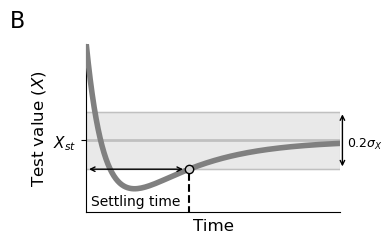

In [46]:
plt.figure(figsize=(4.2,2.5))
ax = plt.subplot(111)
x  = np.arange(0,13,0.1)
A  = -1.5
a  = 0.3
B  = 2.5
b  = 1
y1 = A*np.e**(-a*x)
y2 = B*np.e**(-b*x)
y  = y1 +  y2

eband = 0.3
ax.plot(x,y,c='gray',lw=4,zorder=5)

ax.set_xlim([0,np.max(x)])   ; ax.set_xticks([])       ; ax.set_xlabel('Time', fontsize=12)
ax.set_ylim([-0.75,1]); 

ax.set_yticks([0]); ax.set_ylabel('Test value ($X$)', fontsize=12);
ax.set_yticklabels(['$X_{st}$'],fontsize=11)

stime  = x[np.argmin(np.abs((np.abs(y) - eband)))]
ax.axhline(0,zorder=-4,c='silver',lw=2)
ax.axhline(eband,zorder=-10,c='silver',lw=1)
ax.axhline(-eband,zorder=-10,c='silver',lw=1)
ax.axhspan(-eband,eband,alpha=0.35,zorder=-10,color='silver')

ax.scatter([stime],[-1],c='lightgray',zorder=0,marker='o',edgecolor='k')
ax.scatter([stime],[-eband],c='lightgray',zorder=10,marker='o',edgecolor='k')

ax.plot([stime,stime],[-1,-eband],c='k',ls='--',zorder=-1)
ax.annotate("", xy=(0, -eband), xytext=(stime-0.15, -eband), arrowprops=dict(arrowstyle="<->",color='k'),zorder=10)
ax.annotate("Settling time", xy=(2.5, -0.675),zorder=10,c='k',ha='center',fontsize=10)

ax.annotate("", xy=(13, -eband), xytext=(13, eband), arrowprops=dict(arrowstyle="<->",color='k'),zorder=10, annotation_clip=False)

ax.annotate("0.2$\sigma_{X}$", xy=(13.25, -0.075),zorder=10,c='k',ha='left',fontsize=9, xycoords='data', annotation_clip=False)
ax.annotate("B", xycoords='axes fraction', xy=(-0.3, 1.1), color="k", size=16)

rtimeA = np.log(2)/a
rtimeB = np.log(2)/b

remove_top_right_frame([ax])
plt.tight_layout()
plt.savefig('M_3B.svg',bbox_inches = 'tight',pad_inches=0.1,dpi=300); 
plt.show()

In [47]:
get_postpartum_SDS_stats("WBC").value

0.5     1.268810
1.5     0.976202
2.5     0.465367
3.5     0.160614
4.5     0.020898
          ...   
75.5   -0.008792
76.5    0.016719
77.5    0.028617
78.5   -0.024948
79.5    0.006409
Name: value, Length: 80, dtype: float64

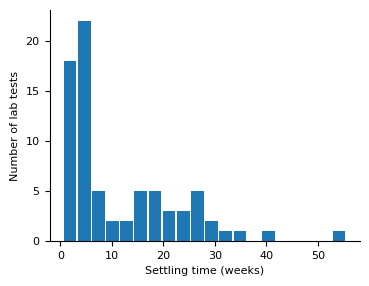

In [48]:
from scipy.ndimage import gaussian_filter

sds_threshold = 0.2
sett_time = []
for i,test in enumerate(tests):

    x,mu,err,n = get_stats_from_dataset(test,'postpartum_SDS',merge_timepoints=False)
    y          = mu.fillna(method='backfill')
    y          = pd.DataFrame(gaussian_filter(y, sigma=1, mode='nearest'),index=y.index)
    
    if np.mean(err) > sds_threshold:
        sett = np.nan
    else:

        sett0 = y.dropna().index[0]
        temp  = (np.abs(y) > sds_threshold).values
        if np.sum(temp) == 0:
            sett  = sett0
        else:
            wsett = np.argwhere(np.array([np.sum(temp[i:])/len(temp[i:]) for i in range(len(temp))])< 0.1)
            if len(wsett)>0:
                try:
                    sett = y.index[wsett[0][0]]
                    sett = y.loc[sett+1:].index[np.argwhere((np.abs(y).loc[sett+1:]<sds_threshold).values)[0][0]]
                except:
                    sett = np.nan
    sett_time.append(sett)
    
plt.figure(figsize=(4,3))
ax1              = plt.subplot(111)
N, bins, patches = ax1.hist(sett_time,bins=20, zorder=2, rwidth=0.9)
ax1.set_xlabel('Settling time (weeks)')
ax1.set_ylabel('Number of lab tests')
remove_top_right_frame([ax1])
plt.show()

In [49]:
group_color ={'Liver'          : def_color[5],
              'Musculoskeletal': def_color[7],
              'Immune'         : def_color[0],
              'RBCs'           : def_color[3],
              'Metabolism'     : def_color[1],
              'Coagulation'    : def_color[4],
              'Endocrine'      : def_color[2],
              'Renal'          : def_color[6]}  

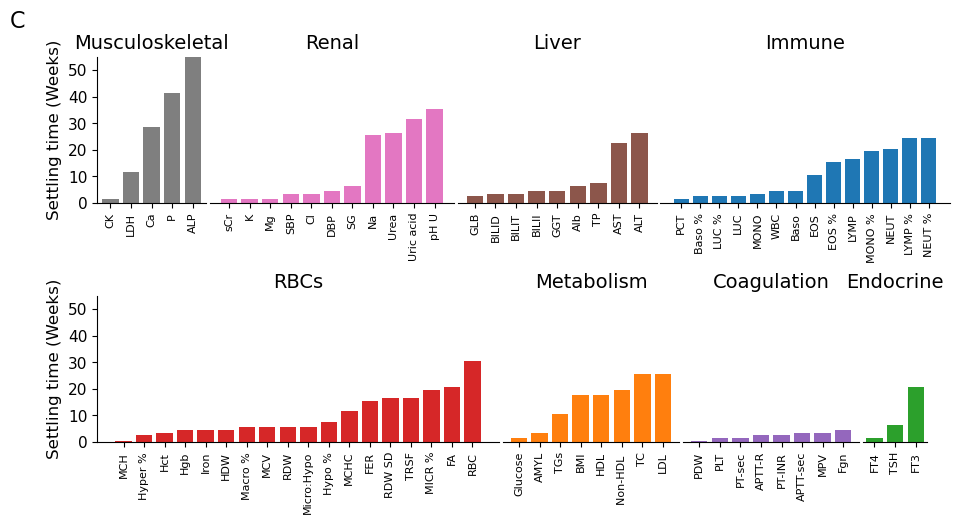

In [50]:
df_sett_time          = pd.DataFrame(sett_time,index=tests,columns=['settling time'])
df_sett_time['Group'] = metadata['Group'].loc[tests]
df_sett_time['test']  = [metadata.loc[test]['Short name'] for test in tests]

def bar_plot_ax(ax,tdf,c, panel=None):
    ax.bar(range(len(tdf)),tdf['settling time'],color=c)
    ax.set_xticks(range(len(tdf)))   
    ax.set_xticklabels(tdf['test'],rotation=90, fontsize=8)
    for ytick_label in ax.get_yticklabels():
        ytick_label.set_fontsize(11)
    ax.set_title(tdf['Group'].iloc[0], fontsize=14)
    ax.set_ylim([0,55])
    ax.yaxis.label.set_fontsize(12)
    remove_top_right_frame([ax])
    if panel is not None:
        ax.annotate(panel, xycoords='axes fraction', xy=(-0.8, 1.2), color="k", size=16)
        
groups_ordered = ['Musculoskeletal','Renal','Liver','Immune','RBCs','Metabolism','Coagulation','Endocrine']
fig = plt.figure(layout="constrained",figsize=(11,5))
gs  = GridSpec(5, 38, figure=fig)

for i,group in enumerate(groups_ordered):
    if i < 4:
        k = 0
    else:
        k = 3
    
    if np.mod(i,4) == 0:
        L0 = 0
        L1 = L0+len(df_sett_time.loc[df_sett_time.Group ==group])
        ax = fig.add_subplot(gs[k:k+2, L0:L1])   
        ax.set_ylabel('Settling time (Weeks)')
    else:
        L1 = L0+len(df_sett_time.loc[df_sett_time.Group ==group])
        ax = fig.add_subplot(gs[k:k+2, L0:L1])   
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)

    bar_plot_ax(ax,df_sett_time.loc[df_sett_time.Group ==group].sort_values(by='settling time'),group_color[group], "C" if i==0 else None)
    L0 = L1
    
plt.subplots_adjust(hspace=0.5,wspace=0.55)    
plt.savefig('M_3C.svg',bbox_inches = 'tight',pad_inches=0.1,dpi=300); 
plt.show()

# Preconception dyanmics

In [51]:
def lin_reg(xdat,a,b):
    return a + b*xdat

summary = []
for i,test in enumerate(tests):
    tdf   = get_test_data(test)['quantile']*100
    ydat  = tdf.loc[:-38]['value'].values
    yerr  = tdf.loc[:-38]['error'].values
    xdat  = tdf.loc[:-38]['value'].index
    n     = tdf.loc[:-38]['n'].values
    popt,pcov  = curve_fit(lin_reg,xdat,ydat,sigma=yerr)
    perr       = np.sqrt(np.diag(pcov))
    zscore     = popt[1]/perr[1]
    summary.append([zscore,*popt,*perr])

reg_res                    = pd.DataFrame(summary,index=tests,columns=['Zscore','intercept','coeff','intercept_sd','coeff_sd'])
reg_res['abs_zscore']      = np.abs(reg_res['Zscore'])
reg_res['pvalue']          = stats.norm.sf(reg_res['abs_zscore']).flat[:]
reg_res['pvalue_adjusted'] = fdrcorrection(reg_res['pvalue'])[1]
reg_res['FDR']             = reg_res['pvalue_adjusted'] < 0.05
reg_res['Name']            = [metadata.loc[test]['Nice name'] for test in reg_res.index]
reg_res['significant']     = (np.abs(reg_res['coeff']) > 0.1) & reg_res['FDR']

In [52]:
df_precon          = pd.DataFrame(reg_res[['coeff','coeff_sd','significant']],index=tests)
df_precon['Group'] = metadata['Group'].loc[tests]
df_precon['test']  = [metadata.loc[test]['Short name'] for test in tests]
df_precon['coeff_ci']    = df_precon['coeff_sd']*2

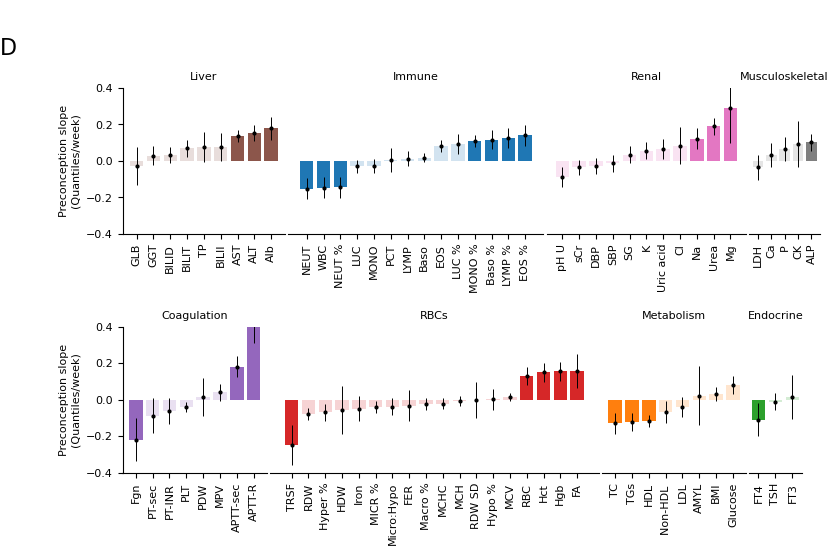

In [53]:
def bar_plot_ax(ax,tdf,c):
    bars = ax.bar(range(len(tdf)),tdf['coeff'],color=c)
    for bar, significant in zip(bars, tdf['significant']):
        if not significant:  # If 'significant' is False
            bar.set_alpha(0.2)  # Set alpha to 0.2
    
    ax.errorbar(range(len(tdf)),tdf['coeff'],tdf['coeff_ci'],color='k',fmt='o',markersize=2,alpha=1,linewidth=0.7)
    ax.set_xticks(range(len(tdf)))   
    ax.set_xticklabels(tdf['test'],rotation=90)   
    ax.set_title(tdf['Group'].iloc[0])
    ax.set_ylim([-0.4,0.4])
    remove_top_right_frame([ax])  

groups_ordered = ['Liver','Immune','Renal','Musculoskeletal','Coagulation','RBCs','Metabolism','Endocrine']

fig = plt.figure(layout="constrained",figsize=(9,5))
gs  = GridSpec(5, 38, figure=fig)
 
for i,group in enumerate(groups_ordered):
    if i < 4:
        k = 0
    else:
        k = 3
    
    if np.mod(i,4) == 0:
        L0 = 0
        L1 = L0+len(df_precon.loc[df_precon.Group ==group])
        ax = fig.add_subplot(gs[k:k+2, L0:L1])   
        ax.set_ylabel('Preconception slope\n(Quantiles/week)')
    else:
        L1 = L0+len(df_precon.loc[df_precon.Group ==group])
        ax = fig.add_subplot(gs[k:k+2, L0:L1])   
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)

    bar_plot_ax(ax,df_precon.loc[df_precon.Group ==group].sort_values(by='coeff'),c=group_color[group])
    L0 = L1

plt.annotate("D", xycoords='figure fraction', xy=(0,1), fontsize=16)    
plt.savefig('M_5B.svg',bbox_inches = 'tight',pad_inches=0.1,dpi=300); 
plt.show()

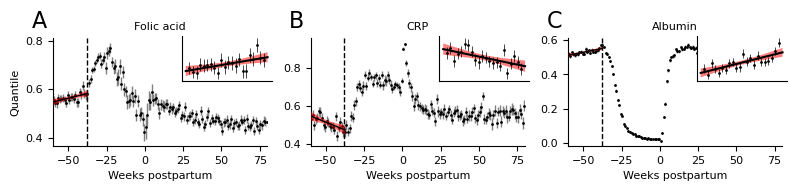

In [54]:
def plot_preconception(test,axi, subplot_label):

    ax    = axi.inset_axes([0.6, 0.6, 0.42, 0.42])
    tdf   = get_test_data(test)['quantile']
    ydat  = tdf.loc[:-38]['value'].values
    yerr  = tdf.loc[:-38]['error'].values
    xdat  = tdf.loc[:-38]['value'].index
    n     = tdf.loc[:-38]['n'].values

    x,v,e,n = get_stats_from_dataset(test,'quantile',merge_timepoints=False)
    axi.errorbar(x,v,e,c='k',lw=1,fmt='o',markersize=1,zorder=-3,ecolor='gray')   

    popt,pcov  = curve_fit(lin_reg,xdat,ydat,sigma=yerr)
    perr       = np.sqrt(np.diag(pcov))
    zscore     = popt[1]/perr[1]
    ypred = lin_reg(xdat,*popt)

    n     = len(ydat)
    m     = len(popt)
    dof   = n - m
    alpha = 0.05
    tails = 2
    t_critical = stats.t.ppf(1 - (alpha / tails), dof)

    y_bar = np.mean(ypred)
    R2    = np.sum((ypred - y_bar)**2) / np.sum((ydat - y_bar)**2)

    resid    = ydat - ypred
    # chi2     = sum((resid / ypred)**2)
    # chi2_red = chi2 / dof
    std_err  = np.sqrt(sum(resid**2) / dof)

    ax.errorbar(xdat, ydat,yerr,fmt='o',c='k',markersize=1,lw=0.5)
    xlim     = ax.get_xlim()
    ylim     = ax.get_ylim()
    x_fitted = np.linspace(xlim[0], xlim[1], 100)
    y_fitted = lin_reg(x_fitted,*popt)
    ci       = t_critical * std_err * np.sqrt(1 / n + (x_fitted - np.mean(xdat))**2 / np.sum((xdat - np.mean(xdat))**2))

    ax.plot(np.array(xlim), popt[0] + popt[1] * np.array(xlim),c='k')
    axi.plot(np.array(xlim), popt[0] + popt[1] * np.array(xlim),lw=1,c='k', zorder=7)

    ax. fill_between(x_fitted, y_fitted + ci, y_fitted - ci, facecolor='r',alpha=0.5, zorder=1)  
    axi.fill_between(x_fitted, y_fitted + ci, y_fitted - ci, facecolor='r',alpha=0.5, zorder=6)   

    axi.set_xlim([-60,80])
    axi.set_xlabel('Weeks postpartum')
    ax.set_xticks([])
    ax.set_yticks([])
    axi.axvline(x=-38,c='k',ls='--',lw=1)
    axi.set_title('')
    axi.set_title(metadata.loc[test]['Nice name'])
    axi.annotate('Conception',(-36,16.5),fontsize=8)
    axi.annotate(subplot_label, xycoords='axes fraction', xy=(-0.1, 1.1), color="k", size=16)
    remove_top_right_frame([axi,ax])
    
    
plt.figure(figsize=(8,2))
ax1,ax2,ax3   = plt.subplot(131),plt.subplot(132),plt.subplot(133)     
plot_preconception('FOLIC_ACID',ax1, "A")
plot_preconception('C_REACTIVE_PROTEIN_CRP',ax2, "B")
plot_preconception('ALBUMIN',ax3, "C")
ax1.set_ylabel('Quantile')
plt.tight_layout();
plt.savefig('M_5ABC.svg',bbox_inches = 'tight',pad_inches=0.1,dpi=300); 
plt.show()

# System by System

In [55]:
def plot_tests_one_axe(ax,tests,title,return_color=False,set_color=None):
    qstd   = pd.DataFrame([data[test]['quantile']['value'].std() for test in tests],index = tests)
    tests_ = qstd.sort_values(by =0,ascending=False).index
    norm   = matplotlib.colors.Normalize(vmin=0, vmax=len(tests_)-1, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.turbo)
    texts = []
    for j,test in enumerate(tests_):
        x,v,e,n = get_stats_from_dataset(test,'quantile')
        offset  = 0.5#v.iloc[:5].mean()
        v       = v - offset
        
        if set_color is None:  
            color = mapper.to_rgba(j)
        else:
            color = set_color[test]
            
        ax.plot(x,v,c=color,lw=0.5,zorder=-3,alpha=0.8-0.4*((len(tests_)-j)/len(tests_)), label=metadata.loc[test]['Nice name'])
        ax.fill_between(x,v+e,v-e,color=color,lw=1,zorder=-3,alpha=0.6-0.45*((len(tests_)-j)/len(tests_)))
        max_min = np.argmax([np.abs(0.5 - v.max()),np.abs(0.5-v.min())])
        xl      = np.array([v.idxmax(),v.idxmin()])[max_min]
        yl      = np.array([v.max(),v.min()])[max_min]
        texts.append(ax.text(xl,yl,metadata.loc[test]['Nice name'],ha='center',fontsize=10,color=color,alpha=0.8-0.4*((len(tests_)-j)/len(tests_))))
    
    ax.set_yticks(np.arange(-0.5,0.75,0.25)); ax.set_ylabel('Quantile Change', fontsize=12); ax.set_ylim([-0.5,0.5]); ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    ax.set_xticks(np.arange(-40,81,20)) ; ax.set_xlabel('Weeks postpartum', fontsize=12); ax.set_xlim([-60,80]);ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.axvspan(-38,0,color='dimgray',alpha=0.1,zorder=-20)
    ax.set_facecolor('w')
    adjust_text(texts, ax=ax)
    remove_top_right_frame([ax])
    # legend = ax.legend(bbox_to_anchor=(1, 0.7), handlelength=2, fontsize=9, loc="upper left")
    # for line in legend.get_lines():
    #     line.set_linewidth(2.8)
    ax.text(-0.15,1.05, title,fontsize=11,color='k', fontweight="bold", transform=ax.transAxes, ha="left")
    
    if return_color:
        colormapper = [(test,mapper.to_rgba(j))for j,test in enumerate(tests_)]
        return colormapper

merge happened in test MAGNESIUM_BLOOD: 2
merge happened in test SPECIFIC_GRAVITY: 2
merge happened in test Cl: 4
merge happened in test GLOBULIN: 6
merge happened in test BILIRUBIN_INDIRECT: 2
merge happened in test HDW: 3
merge happened in test FERRITIN: 2
merge happened in test IRON: 3
merge happened in test FOLIC_ACID: 3
merge happened in test MICROperc_HYPOperc: 2
merge happened in test C_REACTIVE_PROTEIN_CRP: 4
merge happened in test LUC: 2
merge happened in test PDW: 7
merge happened in test MPV: 3
merge happened in test APTT_R: 5
merge happened in test PT_INR: 2
merge happened in test APTT_sec: 2
merge happened in test PT_SEC: 4
merge happened in test HEMOGLOBIN_A1C_CALCULATED: 5
merge happened in test T3_FREE: 2
merge happened in test T4_FREE: 2


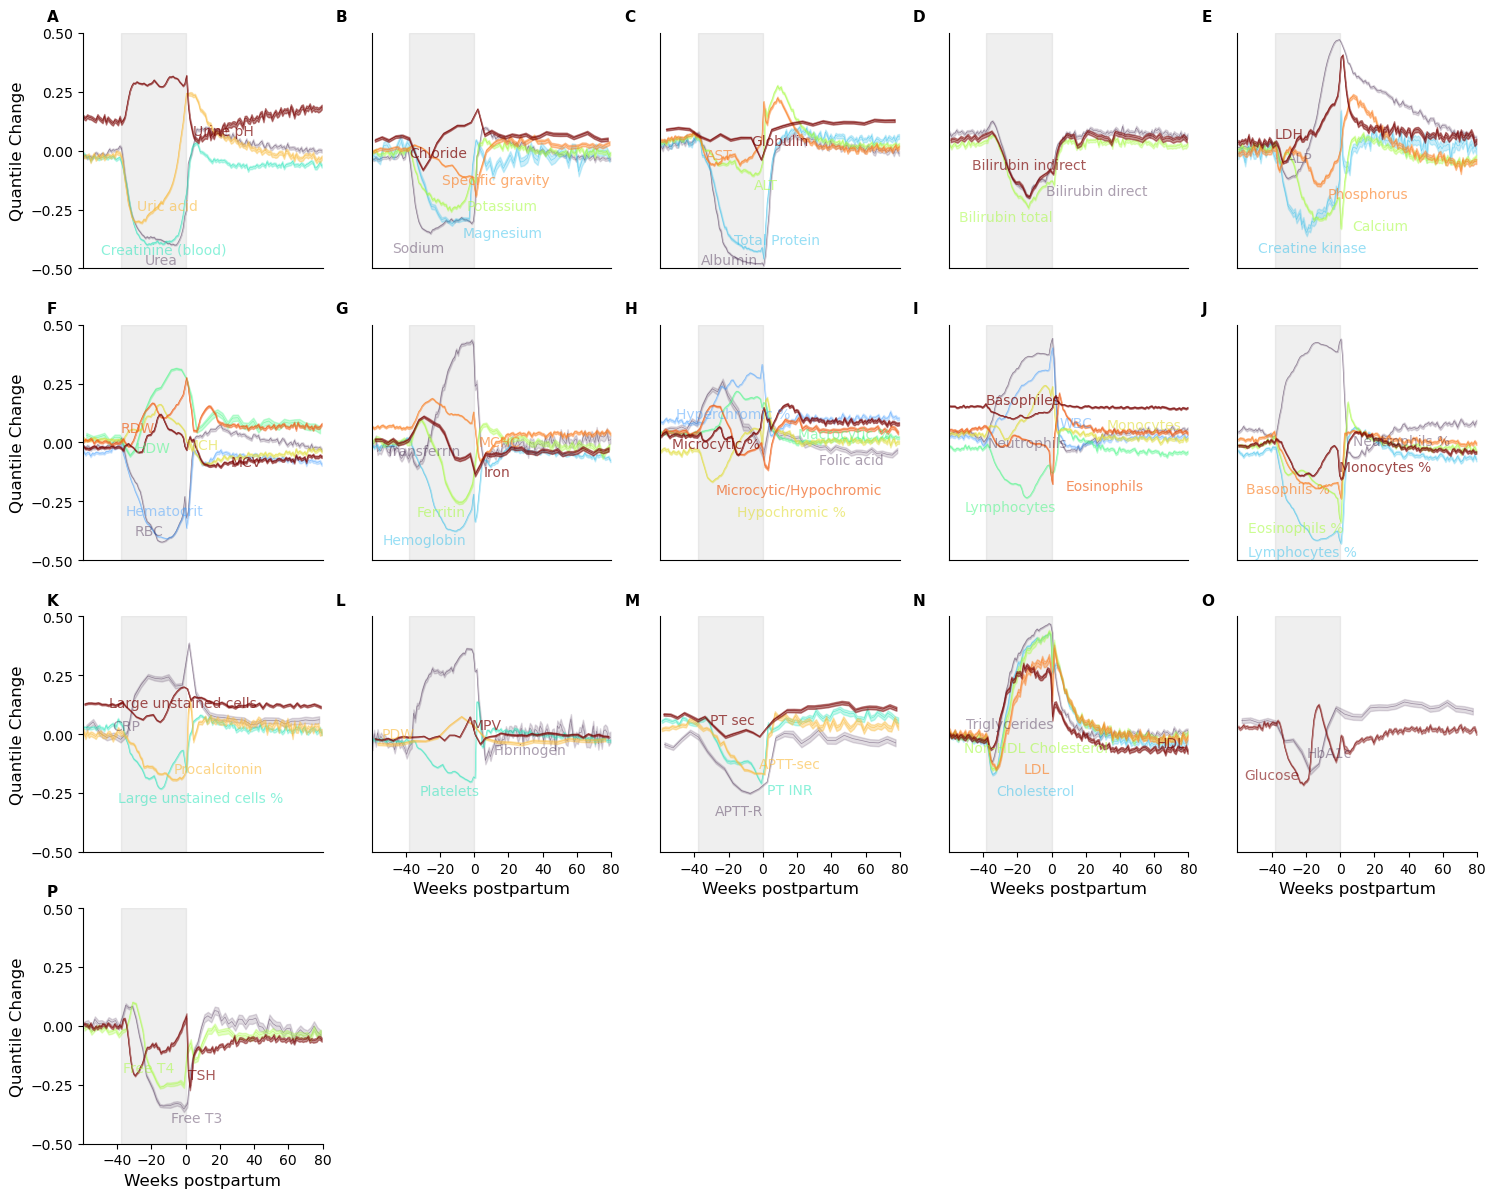

In [56]:
renal_tests = [['CREATININE_BLOOD', 'UREA_BLOOD','URIC_ACID_BLOOD', 'PH_u'], ['Na','K','Cl','MAGNESIUM_BLOOD','SPECIFIC_GRAVITY']]
liver_tests = [['PROTEIN_TOTAL_BLOOD', 'ALBUMIN','GLOBULIN','ALT_Alanine_aminotransferase_GPT', 'AST_Aspartate_aminotransferase_GOT'],
               ['BILIRUBIN_DIRECT','BILIRUBIN_INDIRECT','BILIRUBIN_TOTAL']]
musculoskeletal_tests = [['PHOSPHATASE_ALKALINE', 'LACTIC_DEHYDROGENASE_LDH__BLOOD','PHOSPHORUS_BLOOD', 'CALCIUM_BLOOD','CK_CREAT']]
rbcs_tests = [['RBC', 'HCT','MCV','MCH','RDW','HDW'],
             ['FERRITIN','IRON','HGB','TRANSFERRIN','MCHC'],
             ['MICR_perc','MICROperc_HYPOperc','MACROperc','HYPERperc', 'HYPO_perc','FOLIC_ACID']]
immune_tests = [['NEUT'    ,'EOS'     ,'MONO'   ,'LYMP','BASOPHILES_abs','WBC'],
                ['NEUTperc','EOS_perc','MONperc','LYMperc','BASO_perc'],
                ['C_REACTIVE_PROTEIN_CRP','LUC','LUCperc','PCT']]
coagulation_tests = [['FIBRINOGEN', 'PDW', 'MPV','PLT'], ['PT_SEC','APTT_R','APTT_sec','PT_INR']]
metabolism_tests = [['TRIGLYCERIDES', 'CHOLESTEROL','CHOLESTEROL_HDL', 'CHOLESTEROL_LDL','NON_HDL_CHOLESTEROL'],
                    ['GLUCOSE_BLOOD','HEMOGLOBIN_A1C_CALCULATED']]
endocrine_tests = [metadata.loc[tests][metadata.loc[tests]["Group"] == "Endocrine"].index.values]

all_tests = renal_tests + liver_tests + musculoskeletal_tests + rbcs_tests + immune_tests + coagulation_tests + metabolism_tests + endocrine_tests

panels_per_row = 5
total_rows = (len(all_tests) + 1) // panels_per_row +1
inches_per_ax = 3
fig, axss = plt.subplots(total_rows, panels_per_row, figsize=(panels_per_row * inches_per_ax, total_rows * inches_per_ax))

for i, axs in enumerate(axss):
    for j, ax in enumerate(axs):
        ind = i * panels_per_row + j
        if ind >= len(all_tests):
            ax.set_axis_off()
            continue
        plot_tests = all_tests[ind]
        plot_tests_one_axe(ax, plot_tests, string.ascii_uppercase[ind])
        
        if j > 0:
            ax.set_ylabel('') 
            ax.set_yticklabels([])
            ax.set_yticks([])
        if ind + panels_per_row < len(all_tests):
            ax.set_xlabel('') 
            ax.set_xticklabels([])
            ax.set_xticks([])
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.tight_layout(); plt.savefig('S2_system_by_system.svg',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

merge happened in test MAGNESIUM_BLOOD: 2
merge happened in test SPECIFIC_GRAVITY: 2
merge happened in test Cl: 4


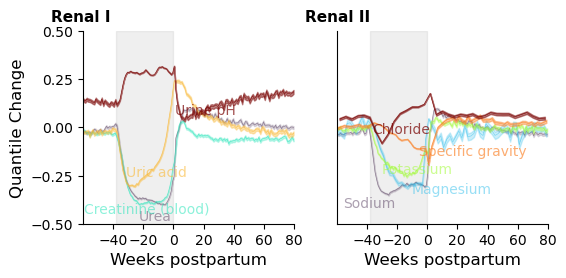

In [57]:
#### Kidney 
plt.figure(figsize=(6,2.5))
ax1  = plt.subplot(1,2,1)
plot_tests_one_axe(ax1,['CREATININE_BLOOD', 'UREA_BLOOD','URIC_ACID_BLOOD', 'PH_u'], 'Renal I')
ax2 = plt.subplot(1,2,2)
plot_tests_one_axe(ax2, ['Na','K','Cl','MAGNESIUM_BLOOD','SPECIFIC_GRAVITY'],'Renal II')
ax2.set_ylabel('') 
ax2.set_yticks([])
# plt.tight_layout(); plt.savefig('M_6_Kidney_overview.svg',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

merge happened in test GLOBULIN: 6
merge happened in test BILIRUBIN_INDIRECT: 2


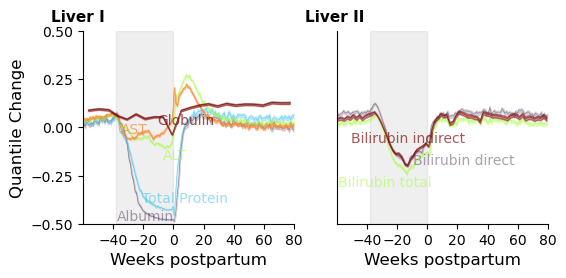

In [58]:
#### Liver
plt.figure(figsize=(6,2.5))
ax1  = plt.subplot(1,2,1)
plot_tests_one_axe(ax1,['PROTEIN_TOTAL_BLOOD', 'ALBUMIN','GLOBULIN','ALT_Alanine_aminotransferase_GPT', 'AST_Aspartate_aminotransferase_GOT'],'Liver I')


ax2 = plt.subplot(1,2,2)
plot_tests_one_axe(ax2,['BILIRUBIN_DIRECT','BILIRUBIN_INDIRECT','BILIRUBIN_TOTAL'],'Liver II')

ax2.set_ylabel('') 
ax2.set_yticklabels([])
ax2.set_yticks([]) 
# plt.tight_layout(); plt.savefig('M_6_Liver_overview.svg',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

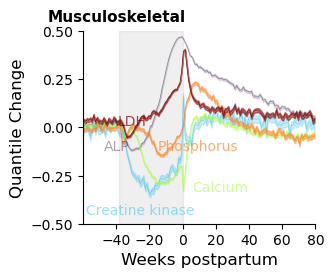

In [59]:
#### Musculoskeletal
plt.figure(figsize=(3,2.5))
ax1 = plt.subplot(1,1,1)
plot_tests_one_axe(ax1,['PHOSPHATASE_ALKALINE', 'LACTIC_DEHYDROGENASE_LDH__BLOOD','PHOSPHORUS_BLOOD',
                        'CALCIUM_BLOOD','CK_CREAT'],'Musculoskeletal')
# plt.tight_layout(); plt.savefig('M_6_Musculoskeletal_overview.svg',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

merge happened in test HDW: 3
merge happened in test FERRITIN: 2
merge happened in test IRON: 3
merge happened in test FOLIC_ACID: 3
merge happened in test MICROperc_HYPOperc: 2


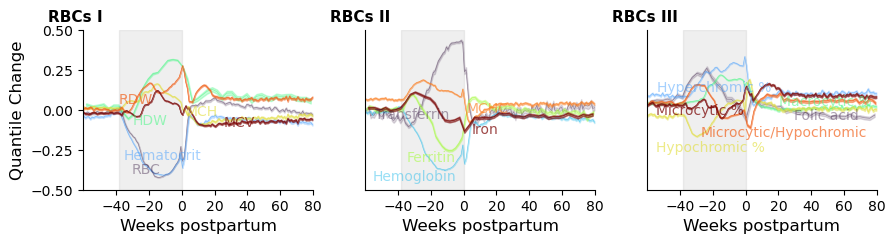

<Figure size 640x480 with 0 Axes>

In [60]:
#### RBCs
plt.figure(figsize=(9,2.5))
ax1 = plt.subplot(1,3,1)
plot_tests_one_axe(ax1,['RBC', 'HCT','MCV','MCH','RDW','HDW'],'RBCs I')
ax2 = plt.subplot(1,3,2)
plot_tests_one_axe(ax2,['FERRITIN','IRON','HGB','TRANSFERRIN','MCHC'],'RBCs II')
ax2.set_ylabel('') 
ax2.set_yticklabels([])
ax2.set_yticks([])  
ax3 = plt.subplot(1,3,3)
plot_tests_one_axe(ax3,['MICR_perc','MICROperc_HYPOperc','MACROperc','HYPERperc',
                        'HYPO_perc','FOLIC_ACID'],'RBCs III')
ax3.set_ylabel('') 
ax3.set_yticklabels([])
ax3.set_yticks([]) 
plt.tight_layout()
plt.show()
plt.clf()
# plt.tight_layout(); plt.savefig('M_6_RBCs_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()


merge happened in test C_REACTIVE_PROTEIN_CRP: 4
merge happened in test LUC: 2


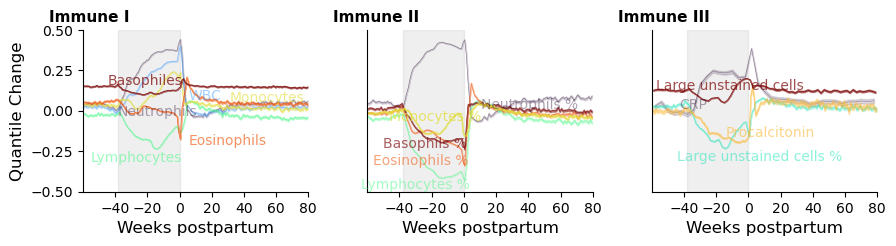

In [61]:
#### Immune
plt.figure(figsize=(9,2.5))
ax1 = plt.subplot(1,3,1)

col_d = plot_tests_one_axe(ax1,['NEUT'    ,'EOS'     ,'MONO'   ,'LYMP','BASOPHILES_abs','WBC'],'Immune I',return_color=True)
plt.tight_layout()
set_col_d = {'NEUTperc':col_d[0][1],
             'EOS_perc':col_d[4][1],
             'MONperc':col_d[3][1],
             'LYMperc':col_d[2][1],
             'BASO_perc':col_d[5][1]}

ax2 = plt.subplot(1,3,2)
plot_tests_one_axe(ax2,['NEUTperc','EOS_perc','MONperc','LYMperc','BASO_perc'],'Immune II',set_color=set_col_d)
ax2.set_ylabel('') 
ax2.set_yticklabels([])
ax2.set_yticks([]) 
ax3  = plt.subplot(1,3,3)
plot_tests_one_axe(ax3,['C_REACTIVE_PROTEIN_CRP','LUC','LUCperc','PCT'],'Immune III') 
ax3.set_ylabel('') 
ax3.set_yticklabels([])
ax3.set_yticks([]) 
plt.tight_layout()
# plt.savefig('M_6_Immune_overview.svg',bbox_inches = 'tight',pad_inches=0.1,dpi=300)


merge happened in test PDW: 7
merge happened in test MPV: 3
merge happened in test APTT_R: 5
merge happened in test PT_INR: 2
merge happened in test APTT_sec: 2
merge happened in test PT_SEC: 4


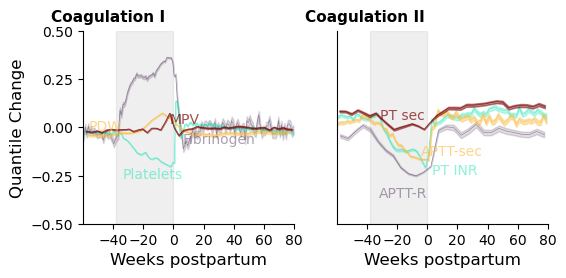

In [62]:
#### Coagulation
plt.figure(figsize=(6,2.5))
ax1   = plt.subplot(1,2,1)
plot_tests_one_axe(ax1,['FIBRINOGEN', 'PDW', 'MPV','PLT'],'Coagulation I')
ax2 = plt.subplot(1,2,2)
plot_tests_one_axe(ax2, ['PT_SEC','APTT_R','APTT_sec','PT_INR'], 'Coagulation II')
ax2.set_ylabel("")
ax2.set_yticks([])
# plt.tight_layout(); plt.savefig('M_6_Coagulation_overview.svg',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

merge happened in test HEMOGLOBIN_A1C_CALCULATED: 5
merge happened in test T3_FREE: 2
merge happened in test T4_FREE: 2


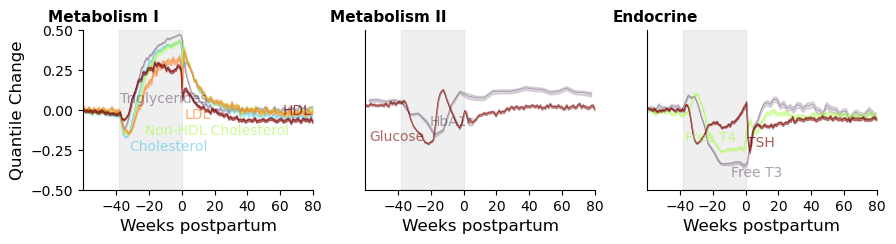

In [63]:
#### Metabolism
plt.figure(figsize=(9,2.5))
ax1 = plt.subplot(1,3,1)
plot_tests_one_axe(ax1,['TRIGLYCERIDES', 'CHOLESTEROL','CHOLESTEROL_HDL',
                        'CHOLESTEROL_LDL','NON_HDL_CHOLESTEROL'],'Metabolism I')

ax2 = plt.subplot(1,3,2)
plot_tests_one_axe(ax2, ['GLUCOSE_BLOOD','HEMOGLOBIN_A1C_CALCULATED'], "Metabolism II")
ax2.set_ylabel("")
ax2.set_yticks([])

##Endocrine
endocrine_tests = metadata.loc[tests][metadata.loc[tests]["Group"] == "Endocrine"].index.values
ax3 = plt.subplot(1,3,3)
plot_tests_one_axe(ax3,endocrine_tests,'Endocrine')
ax3.set_ylabel('') 
ax3.set_yticklabels([])
ax3.set_yticks([]) 
plt.tight_layout()
# plt.savefig('M_6_Metabolism_overview.svg',bbox_inches = 'tight')
plt.show()